# Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install pycaret

In [27]:
# import pycaret
# import pandas as pd
# from sklearn.model_selection import train_test_split

In [1]:
import pandas as pd

# import catboost
import lightgbm as lgb
import optuna
import seaborn as sns
import numpy as np
import shap
import decoupler as dc
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_predict

from optuna.samplers import RandomSampler

from matplotlib import pyplot as plt

from lightgbm import LGBMClassifier

# Build metadata table

In [2]:
metadata = pd.read_csv("metadata/data_clinical_patient.txt", sep="\t")
metadata.head()

#Other Patient ID  \
0  #Legacy DMP patient identifier (DMPnnnn)   
1                                   #STRING   
2                                        #1   
3                          OTHER_PATIENT_ID   
4      34040b83-7e8a-4264-a551-b16621843e28   

                          Patient Identifier  Form completion date  \
0  Identifier to uniquely specify a patient.  Form completion date   
1                                     STRING                STRING   
2                                          1                     1   
3                                 PATIENT_ID  FORM_COMPLETION_DATE   
4                               TCGA-05-4244               7/22/10   

                       Neoplasm Histologic Type Name  \
0  Text term for the structural pattern of cancer...   
1                                             STRING   
2                                                  1   
3                             HISTOLOGICAL_DIAGNOSIS   
4                                Lung Adenocarcinoma   

             Tissue Prospective Collection Indicator  \
0  Text indicator for the time frame of tissue pr...   
1                                             STRING   
2                                                  1   
3                             PROSPECTIVE_COLLECTION   
4                                                 NO   

           Tissue Retrospective Collection Indicator     Sex  Tumor Site  \
0  Text indicator for the time frame of tissue pr...     Sex  Tumor Site   
1                                             STRING  STRING      STRING   
2                                                  1       1           1   
3                           RETROSPECTIVE_COLLECTION     SEX  TUMOR_SITE   
4                                                YES    MALE        Lung   

                                    Race Category  \
0  The text for reporting information about race.   
1                                          STRING   
2                                               1   
3                                            RACE   
4                                 [Not Available]   

                                  Ethnicity Category  ...  \
0  The text for reporting information about ethni...  ...   
1                                             STRING  ...   
2                                                  1  ...   
3                                          ETHNICITY  ...   
4                                    [Not Available]  ...   

   Number of lymphnodes positive by ihc  \
0  Number of lymphnodes positive by ihc   
1                                STRING   
2                                     1   
3  NUMBER_OF_LYMPHNODES_POSITIVE_BY_IHC   
4                       [Not Available]   

   Lymph node location positive pathology name     Project code  \
0  Lymph node location positive pathology name     Project code   
1                                       STRING           STRING   
2                                            1                1   
3                      POS_LYMPH_NODE_LOCATION     PROJECT_CODE   
4                              [Not Available]  [Not Available]   

       Stage Other  \
0      Stage Other   
1           STRING   
2                1   
3      STAGE_OTHER   
4  [Not Available]   

  Adjuvant Postoperative Targeted Therapy Administered Indicator  \
0  Text term to signify postoperative adjuvant ca...               
1                                             STRING               
2                                                  1               
3                         TARGETED_MOLECULAR_THERAPY               
4                                    [Not Available]               

                                  Tissue Source Site  \
0  A Tissue Source Site collects samples (tissue,...   
1                                             STRING   
2                                                  1   
3                                 TISSUE_SOURCE_SITE   
4                    

In [3]:
metadata_short = metadata[
    [
        "Patient Identifier",
        "Patient Smoking History Category",
        "Started Smoking Year",
        "Stopped Smoking Year",
        "Form completion date",
    ]
]
metadata_short.columns = metadata_short.iloc[3,]
metadata_short = metadata_short.iloc[4:,]
metadata_short = metadata_short.reset_index().drop(columns="index")

metadata_short.head()

3    PATIENT_ID TOBACCO_SMOKING_HISTORY_INDICATOR SMOKING_YEAR_STARTED  \
0  TCGA-05-4244                                 4      [Not Available]   
1  TCGA-05-4245                                 4      [Not Available]   
2  TCGA-05-4249                                 3      [Not Available]   
3  TCGA-05-4250                                 4      [Not Available]   
4  TCGA-05-4382                                 4      [Not Available]   

3 SMOKING_YEAR_STOPPED FORM_COMPLETION_DATE  
0      [Not Available]              7/22/10  
1      [Not Available]              7/22/10  
2      [Not Available]              7/22/10  
3      [Not Available]              7/22/10  
4      [Not Available]              7/22/10

# Build target variable

In [8]:
metadata_short = metadata_short.replace("[Not Available]", 0)
metadata_short.TOBACCO_SMOKING_HISTORY_INDICATOR = pd.to_numeric(
    metadata_short.TOBACCO_SMOKING_HISTORY_INDICATOR
)
print(metadata_short.shape)
metadata_short.TOBACCO_SMOKING_HISTORY_INDICATOR.value_counts()

(522, 5)


TOBACCO_SMOKING_HISTORY_INDICATOR
4    170
3    137
2    122
1     75
0     14
5      4
Name: count, dtype: int64

In [9]:
metadata_short_filtered = metadata_short[
    (metadata_short["TOBACCO_SMOKING_HISTORY_INDICATOR"] != 0)
    & (metadata_short["TOBACCO_SMOKING_HISTORY_INDICATOR"] != 5)
]
(metadata_short_filtered.shape, metadata_short.shape)

((504, 5), (522, 5))

In [16]:
metadata_short_filtered["smoking_status"] = (
    metadata_short_filtered.TOBACCO_SMOKING_HISTORY_INDICATOR.map(
        {1: 0, 2: 1, 3: 0, 4: 1}
    )
)
metadata_short_status = metadata_short_filtered[["PATIENT_ID", "smoking_status"]]
metadata_short_status.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3    PATIENT_ID  smoking_status
0  TCGA-05-4244               1
1  TCGA-05-4245               1
2  TCGA-05-4249               0
3  TCGA-05-4250               1
4  TCGA-05-4382               1

In [17]:
metadata_short_status_multiclass = metadata_short_filtered[
    ["PATIENT_ID", "TOBACCO_SMOKING_HISTORY_INDICATOR"]
]

In [18]:
metadata_short_status.to_csv("data/tables/meta_short_status.csv")
metadata_short_status_multiclass.to_csv("data/tables/meta_short_status_multiclass.csv")

# Build matrix of counts

In [41]:
counts = pd.read_csv("data/TCGA-LUAD.htseq_counts.protein_coding.csv", index_col=-1)
counts.head()

TCGA-97-7938-01A  TCGA-55-7574-01A  TCGA-05-4250-01A  \
symbol                                                           
TSPAN6           10.989394          9.967226         12.386940   
TNMD              4.000000          0.000000          2.584963   
DPM1             10.253847          9.541097         11.501340   
SCYL3             9.776433          9.131857          9.521600   
C1orf112          7.971544          8.348728          9.618386   

          TCGA-55-6979-11A  TCGA-95-A4VK-01A  TCGA-97-A4M6-01A  \
symbol                                                           
TSPAN6            9.014020         11.148477         12.854479   
TNMD              0.000000          1.000000          2.321928   
DPM1              9.204571          9.679480         10.366322   
SCYL3             8.499846         10.529431         10.737247   
C1orf112          6.475733          8.357552          8.672425   

          TCGA-78-7155-01A  TCGA-05-4402-01A  TCGA-91-6831-11A  \
symbol                                                           
TSPAN6           11.935165         13.670324          8.451211   
TNMD              3.169925          2.807355          0.000000   
DPM1             10.221587         11.107217          9.569856   
SCYL3             8.951285         10.841564          8.262095   
C1orf112          9.832890          9.658211          5.491853   

          TCGA-MP-A4T4-01A  ...  TCGA-86-7714-01A  TCGA-55-6970-11A  \
symbol                      ...                                       
TSPAN6           11.089450  ...         11.132500          9.632995   
TNMD              0.000000  ...          1.584963          0.000000   
DPM1             10.638436  ...          9.485829          9.616549   
SCYL3             9.850187  ...          8.945444          8.797662   
C1orf112          8.738092  ...          7.467606          6.375039   

          TCGA-44-6145-11A  TCGA-86-8076-01A  TCGA-50-5068-01A  \
symbol                                                           
TSPAN6            9.612868         11.681678         11.504322   
TNMD              1.584963          0.000000          1.584963   
DPM1              9.971544         10.594325         11.636171   
SCYL3             8.603626         10.464546          9.734710   
C1orf112          6.228819          8.483816          8.124121   

          TCGA-97-7937-01A  TCGA-05-4398-01A  TCGA-50-6592-01A  \
symbol                                                           
TSPAN6           12.095727         12.571516         11.709515   
TNMD              0.000000          2.000000          1.000000   
DPM1             11.658658         11.868437         11.298063   
SCYL3            10.703038         10.619303          9.612868   
C1orf112          9.505812         10.428360          9.455327   

          TCGA-44-3396-01A  TCGA-91-6849-11A  
symbol                                        
TSPAN6           13.151017         10.359750  
TNMD              2.000000          1.000000  
DPM1             12.147523          9.645658  
SCYL3            10.192293          8.900867  
C1orf112          9.939579          6.303781  

[5 rows x 585 columns]

In [65]:
counts_t = counts.transpose()
patients_before_filter = counts_t.shape[0]
counts_t.reset_index(inplace=True)
counts_t.rename(columns={"index": "PATIENT_ID"}, inplace=True)
# counts_t = counts_t.iloc[:,1:]
counts_t["PATIENT_ID"] = counts_t["PATIENT_ID"].str.slice(0, -2)
counts_t[counts_t["PATIENT_ID"].duplicated(keep=False)].sort_values(by="PATIENT_ID")
counts_t = counts_t[counts_t["PATIENT_ID"].str.contains("0$", regex=True)]
counts_t["PATIENT_ID"] = counts_t["PATIENT_ID"].str.slice(0, -2)
patients_after_filter = counts_t.shape[0]
print((patients_before_filter - patients_after_filter), patients_after_filter)
counts_t.head()

59 526


symbol    PATIENT_ID     TSPAN6      TNMD       DPM1      SCYL3  C1orf112  \
0       TCGA-97-7938  10.989394  4.000000  10.253847   9.776433  7.971544   
1       TCGA-55-7574   9.967226  0.000000   9.541097   9.131857  8.348728   
2       TCGA-05-4250  12.386940  2.584963  11.501340   9.521600  9.618386   
4       TCGA-95-A4VK  11.148477  1.000000   9.679480  10.529431  8.357552   
5       TCGA-97-A4M6  12.854479  2.321928  10.366322  10.737247  8.672425   

symbol        FGR        CFH      FUCA2       GCLC  ...  OR12D2  PRAMEF26  \
0        8.724514  11.712957  10.404077   9.832890  ...     1.0       0.0   
1        9.703904  11.850968  10.648358   9.941048  ...     0.0       0.0   
2       10.536247  12.149112  12.364955  11.474720  ...     0.0       0.0   
4        9.238405  10.134426  11.471675  10.840778  ...     0.0       0.0   
5       10.294621  13.898223  11.390706  11.311181  ...     0.0       0.0   

symbol  OR8K3   CCDC163  LINC02203     PAGR1  RPS4Y2   TMEM272   BLACAT1  \
0         0.0  7.238405        0.0  6.845490     0.0  1.000000  7.643856   
1         0.0  7.375039        0.0  7.417853     0.0  3.459432  6.768184   
2         0.0  5.754888        0.0  7.954196     0.0  0.000000  9.090112   
4         0.0  7.577429        0.0  8.879583     0.0  3.321928  7.748193   
5         0.0  6.357552        0.0  8.632995     0.0  4.247928  9.262095   

symbol  GIMAP1-GIMAP5  
0                 0.0  
1                 0.0  
2                 0.0  
4                 0.0  
5                 0.0  

[5 rows x 19243 columns]

In [66]:
counts_t.to_csv("data/tables/counts_transposed_trunkated_patient_id.csv")

# Merge matrix of counts with metadata

In [27]:
meta = pd.read_csv("data/tables/meta_short_status.csv", index_col=0)
print(meta.shape)
meta.head()

(504, 2)


PATIENT_ID  smoking_status
0  TCGA-05-4244               1
1  TCGA-05-4245               1
2  TCGA-05-4249               0
3  TCGA-05-4250               1
4  TCGA-05-4382               1

In [28]:
meta_multiclass = pd.read_csv(
    "data/tables/meta_short_status_multiclass.csv", index_col=0
)
print(meta_multiclass.shape)
meta_multiclass.head()

(504, 2)


PATIENT_ID  TOBACCO_SMOKING_HISTORY_INDICATOR
0  TCGA-05-4244                                  4
1  TCGA-05-4245                                  4
2  TCGA-05-4249                                  3
3  TCGA-05-4250                                  4
4  TCGA-05-4382                                  4

In [29]:
counts_t = pd.read_csv(
    "data/tables/counts_transposed_trunkated_patient_id.csv", index_col=0
)
counts_t = counts_t[~counts_t["PATIENT_ID"].duplicated()]
print(counts_t.shape)
counts_t.head()

(513, 19243)


PATIENT_ID     TSPAN6      TNMD       DPM1      SCYL3  C1orf112  \
0  TCGA-97-7938  10.989394  4.000000  10.253847   9.776433  7.971544   
1  TCGA-55-7574   9.967226  0.000000   9.541097   9.131857  8.348728   
2  TCGA-05-4250  12.386940  2.584963  11.501340   9.521600  9.618386   
4  TCGA-95-A4VK  11.148477  1.000000   9.679480  10.529431  8.357552   
5  TCGA-97-A4M6  12.854479  2.321928  10.366322  10.737247  8.672425   

         FGR        CFH      FUCA2       GCLC  ...  OR12D2  PRAMEF26  OR8K3  \
0   8.724514  11.712957  10.404077   9.832890  ...     1.0       0.0    0.0   
1   9.703904  11.850968  10.648358   9.941048  ...     0.0       0.0    0.0   
2  10.536247  12.149112  12.364955  11.474720  ...     0.0       0.0    0.0   
4   9.238405  10.134426  11.471675  10.840778  ...     0.0       0.0    0.0   
5  10.294621  13.898223  11.390706  11.311181  ...     0.0       0.0    0.0   

    CCDC163  LINC02203     PAGR1  RPS4Y2   TMEM272   BLACAT1  GIMAP1-GIMAP5  
0  7.238405        0.0  6.845490     0.0  1.000000  7.643856            0.0  
1  7.375039        0.0  7.417853     0.0  3.459432  6.768184            0.0  
2  5.754888        0.0  7.954196     0.0  0.000000  9.090112            0.0  
4  7.577429        0.0  8.879583     0.0  3.321928  7.748193            0.0  
5  6.357552        0.0  8.632995     0.0  4.247928  9.262095            0.0  

[5 rows x 19243 columns]

In [30]:
print(
    f'duplicates in meta {meta['PATIENT_ID'].duplicated().sum()} \nduplicates in counts {counts_t['PATIENT_ID'].duplicated().sum()}'
)

duplicates in meta 0 
duplicates in counts 0


In [31]:
counts_t_merged = meta.merge(counts_t, on="PATIENT_ID", how="inner")
columns = counts_t_merged.columns.to_list()
columns = columns[60489:] + columns[:60489]
counts_t_merged = counts_t_merged[columns]
counts_t_merged.head()
print(counts_t_merged.shape)

(495, 19244)


In [32]:
counts_t_merged_multiclass = meta_multiclass.merge(
    counts_t, on="PATIENT_ID", how="inner"
)
columns = counts_t_merged_multiclass.columns.to_list()
columns = columns[60489:] + columns[:60489]
counts_t_merged_multiclass = counts_t_merged_multiclass[columns]
counts_t_merged_multiclass.head()
print(counts_t_merged_multiclass.shape)

(495, 19244)


In [33]:
counts_t_merged.smoking_status.value_counts()

smoking_status
1    286
0    209
Name: count, dtype: int64

In [34]:
counts_t_merged_multiclass.TOBACCO_SMOKING_HISTORY_INDICATOR.value_counts()

TOBACCO_SMOKING_HISTORY_INDICATOR
4    166
3    135
2    120
1     74
Name: count, dtype: int64

In [35]:
counts_t_merged.head()

PATIENT_ID  smoking_status     TSPAN6      TNMD       DPM1      SCYL3  \
0  TCGA-05-4244               1  12.295769  0.000000  10.512740  10.551708   
1  TCGA-05-4249               0  12.108524  0.000000  10.980140  10.885696   
2  TCGA-05-4250               1  12.386940  2.584963  11.501340   9.521600   
3  TCGA-05-4382               1  11.928888  0.000000  11.468115  10.220378   
4  TCGA-05-4384               0  10.396605  0.000000   9.831307   9.946906   

   C1orf112        FGR        CFH      FUCA2  ...  OR12D2  PRAMEF26  OR8K3  \
0  9.761551  10.950556  11.543032  12.137311  ...     0.0       0.0    0.0   
1  9.022368  10.253847  11.429930  11.809366  ...     0.0       0.0    0.0   
2  9.618386  10.536247  12.149112  12.364955  ...     0.0       0.0    0.0   
3  9.632995  12.194757  13.085970  13.088623  ...     0.0       0.0    0.0   
4  7.714246  10.041659  10.583083  10.728771  ...     0.0       0.0    0.0   

    CCDC163  LINC02203     PAGR1  RPS4Y2   TMEM272    BLACAT1  GIMAP1-GIMAP5  
0  6.700440        0.0  9.174926     1.0  2.584963  10.634811            0.0  
1  7.055282        0.0  8.149747     0.0  3.000000   9.552669            0.0  
2  5.754888        0.0  7.954196     0.0  0.000000   9.090112            0.0  
3  9.335390        0.0  9.060696     1.0  2.584963   6.643856            0.0  
4  5.807355        0.0  7.614710     2.0  1.000000   6.906891            0.0  

[5 rows x 19244 columns]

In [36]:
counts_t_merged.to_csv("data/tables/counts_meta.csv")
counts_t_merged_multiclass.to_csv("data/tables/counts_meta_multiclass.csv")

# Split dataframe

In [2]:
counts_meta = pd.read_csv("data/tables/counts_meta.csv", index_col=0)
counts_meta.set_index("PATIENT_ID", inplace=True)
print(counts_meta.shape)
counts_meta.head()

(495, 19243)


smoking_status     TSPAN6      TNMD       DPM1      SCYL3  \
PATIENT_ID                                                                
TCGA-05-4244               1  12.295769  0.000000  10.512740  10.551708   
TCGA-05-4249               0  12.108524  0.000000  10.980140  10.885696   
TCGA-05-4250               1  12.386940  2.584963  11.501340   9.521600   
TCGA-05-4382               1  11.928888  0.000000  11.468115  10.220378   
TCGA-05-4384               0  10.396605  0.000000   9.831307   9.946906   

              C1orf112        FGR        CFH      FUCA2       GCLC  ...  \
PATIENT_ID                                                          ...   
TCGA-05-4244  9.761551  10.950556  11.543032  12.137311  11.611947  ...   
TCGA-05-4249  9.022368  10.253847  11.429930  11.809366  10.628446  ...   
TCGA-05-4250  9.618386  10.536247  12.149112  12.364955  11.474720  ...   
TCGA-05-4382  9.632995  12.194757  13.085970  13.088623  12.535032  ...   
TCGA-05-4384  7.714246  10.041659  10.583083  10.728771  12.695881  ...   

              OR12D2  PRAMEF26  OR8K3   CCDC163  LINC02203     PAGR1  RPS4Y2  \
PATIENT_ID                                                                     
TCGA-05-4244     0.0       0.0    0.0  6.700440        0.0  9.174926     1.0   
TCGA-05-4249     0.0       0.0    0.0  7.055282        0.0  8.149747     0.0   
TCGA-05-4250     0.0       0.0    0.0  5.754888        0.0  7.954196     0.0   
TCGA-05-4382     0.0       0.0    0.0  9.335390        0.0  9.060696     1.0   
TCGA-05-4384     0.0       0.0    0.0  5.807355        0.0  7.614710     2.0   

               TMEM272    BLACAT1  GIMAP1-GIMAP5  
PATIENT_ID                                        
TCGA-05-4244  2.584963  10.634811            0.0  
TCGA-05-4249  3.000000   9.552669            0.0  
TCGA-05-4250  0.000000   9.090112            0.0  
TCGA-05-4382  2.584963   6.643856            0.0  
TCGA-05-4384  1.000000   6.906891            0.0  

[5 rows x 19243 columns]

In [3]:
counts_meta_multiclass = pd.read_csv(
    "data/tables/counts_meta_multiclass.csv", index_col=0
)
counts_meta_multiclass.set_index("PATIENT_ID", inplace=True)
print(counts_meta_multiclass.shape)
counts_meta_multiclass.head()

(495, 19243)


TOBACCO_SMOKING_HISTORY_INDICATOR     TSPAN6      TNMD  \
PATIENT_ID                                                             
TCGA-05-4244                                  4  12.295769  0.000000   
TCGA-05-4249                                  3  12.108524  0.000000   
TCGA-05-4250                                  4  12.386940  2.584963   
TCGA-05-4382                                  4  11.928888  0.000000   
TCGA-05-4384                                  3  10.396605  0.000000   

                   DPM1      SCYL3  C1orf112        FGR        CFH      FUCA2  \
PATIENT_ID                                                                      
TCGA-05-4244  10.512740  10.551708  9.761551  10.950556  11.543032  12.137311   
TCGA-05-4249  10.980140  10.885696  9.022368  10.253847  11.429930  11.809366   
TCGA-05-4250  11.501340   9.521600  9.618386  10.536247  12.149112  12.364955   
TCGA-05-4382  11.468115  10.220378  9.632995  12.194757  13.085970  13.088623   
TCGA-05-4384   9.831307   9.946906  7.714246  10.041659  10.583083  10.728771   

                   GCLC  ...  OR12D2  PRAMEF26  OR8K3   CCDC163  LINC02203  \
PATIENT_ID               ...                                                 
TCGA-05-4244  11.611947  ...     0.0       0.0    0.0  6.700440        0.0   
TCGA-05-4249  10.628446  ...     0.0       0.0    0.0  7.055282        0.0   
TCGA-05-4250  11.474720  ...     0.0       0.0    0.0  5.754888        0.0   
TCGA-05-4382  12.535032  ...     0.0       0.0    0.0  9.335390        0.0   
TCGA-05-4384  12.695881  ...     0.0       0.0    0.0  5.807355        0.0   

                 PAGR1  RPS4Y2   TMEM272    BLACAT1  GIMAP1-GIMAP5  
PATIENT_ID                                                          
TCGA-05-4244  9.174926     1.0  2.584963  10.634811            0.0  
TCGA-05-4249  8.149747     0.0  3.000000   9.552669            0.0  
TCGA-05-4250  7.954196     0.0  0.000000   9.090112            0.0  
TCGA-05-4382  9.060696     1.0  2.584963   6.643856            0.0  
TCGA-05-4384  7.614710     2.0  1.000000   6.906891            0.0  

[5 rows x 19243 columns]

In [4]:
counts_meta.smoking_status.value_counts() / len(counts_meta.smoking_status) * 100

smoking_status
1    57.777778
0    42.222222
Name: count, dtype: float64

In [5]:
counts_meta_multiclass.TOBACCO_SMOKING_HISTORY_INDICATOR.value_counts() / len(
    counts_meta_multiclass.TOBACCO_SMOKING_HISTORY_INDICATOR
) * 100

TOBACCO_SMOKING_HISTORY_INDICATOR
4    33.535354
3    27.272727
2    24.242424
1    14.949495
Name: count, dtype: float64

In [6]:
X = counts_meta.drop(columns="smoking_status")
y = counts_meta["smoking_status"]

In [7]:
X_multiclass = counts_meta_multiclass.drop(columns="TOBACCO_SMOKING_HISTORY_INDICATOR")
y_multiclass = counts_meta_multiclass["TOBACCO_SMOKING_HISTORY_INDICATOR"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [9]:
(X_train.shape, X_test.shape)

((396, 19242), (99, 19242))

# Logistic Regression

In [118]:
lr_model = LogisticRegression(max_iter=1000, solver="saga", penalty="l1")

param_grid = {"penalty": ["l1", "l2"]}

In [11]:
# from sklearn.model_selection import GridSearchCV

# grid_search = GridSearchCV(lr_model, param_grid, scoring='accuracy',
#                                    cv=5, verbose=1, n_jobs=-1)
# grid_search.fit(X_train, y_train)

In [12]:
# print("Best Hyperparameters:", grid_search.best_params_)

In [13]:
# lr_best_model = random_search.best_estimator_
# lr_best_model.fit(X_train, y_train)

In [119]:
lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

print(f"train {classification_report(y_train_pred, y_train)}")
print(f"test {classification_report(y_test_pred, y_test)}")

The max_iter was reached which means the coef_ did not converge


train               precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00       236

    accuracy                           1.00       396
   macro avg       1.00      1.00      1.00       396
weighted avg       1.00      1.00      1.00       396

test               precision    recall  f1-score   support

           0       0.63      0.72      0.67        43
           1       0.76      0.68      0.72        56

    accuracy                           0.70        99
   macro avg       0.70      0.70      0.70        99
weighted avg       0.70      0.70      0.70        99



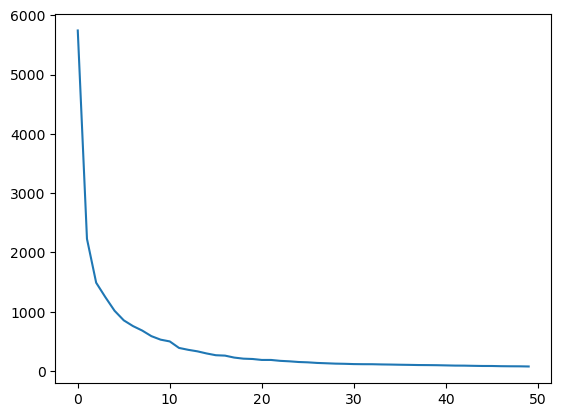

In [120]:
pca = PCA()
pca.fit(X.iloc[:, 1:])

plt.plot(pca.explained_variance_[:50]);

In [132]:
pca = PCA(30)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


logreg = LogisticRegression()

logreg.fit(X_train_pca, y_train)

y_train_pred = logreg.predict(X_train_pca)
y_test_pred = logreg.predict(X_test_pca)

print("LOGREG ---------------------------")

print(f"train {classification_report(y_train_pred, y_train)}")
print(f"test {classification_report(y_test_pred, y_test)}")

svc = SVC()

svc.fit(X_train_pca, y_train)

y_train_pred = svc.predict(X_train_pca)
y_test_pred = svc.predict(X_test_pca)

print("SVM ------------------------------")

print(f"train {classification_report(y_train_pred, y_train)}")
print(f"test {classification_report(y_test_pred, y_test)}")

LOGREG ---------------------------
train               precision    recall  f1-score   support

           0       0.62      0.72      0.67       139
           1       0.83      0.77      0.80       257

    accuracy                           0.75       396
   macro avg       0.73      0.74      0.73       396
weighted avg       0.76      0.75      0.75       396

test               precision    recall  f1-score   support

           0       0.59      0.67      0.63        43
           1       0.72      0.64      0.68        56

    accuracy                           0.66        99
   macro avg       0.66      0.66      0.65        99
weighted avg       0.66      0.66      0.66        99

SVM ------------------------------
train               precision    recall  f1-score   support

           0       0.76      0.86      0.81       142
           1       0.92      0.85      0.88       254

    accuracy                           0.85       396
   macro avg       0.84      0.85      0.

In [121]:
pca_train = PCA()
pca_train.fit(X_train)
pc_20_train = pca_train.components_[:, :20]

X_test_pca = pca_train.transform(X_test)
pc_20_test = X_test_pca[:, :20]

lr_model.fit(pc_20_train, y_train)

y_train_pred = lr_model.predict(pc_20_train)
y_test_pred = lr_model.predict(pc_20_test)

print(f"train {classification_report(y_train_pred, y_train)}")
print(f"test {classification_report(y_test_pred, y_test)}")

train               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.60      0.75       396

    accuracy                           0.60       396
   macro avg       0.50      0.30      0.37       396
weighted avg       1.00      0.60      0.75       396

test               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.51      0.67        99

    accuracy                           0.51        99
   macro avg       0.50      0.25      0.34        99
weighted avg       1.00      0.51      0.67        99



Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


# Random Forest

In [9]:
random_f_clf = RandomForestClassifier()
random_f_clf.fit(X_train, y_train)

y_train_pred_random_f_clf = random_f_clf.predict(X_train)
y_test_pred_random_f_clf = random_f_clf.predict(X_test)

print(f"train {classification_report(y_train_pred_random_f_clf, y_train)}")
print(f"test {classification_report(y_test_pred_random_f_clf, y_test)}")

train               precision    recall  f1-score   support

           0       1.00      1.00      1.00       161
           1       1.00      1.00      1.00       234

    accuracy                           1.00       395
   macro avg       1.00      1.00      1.00       395
weighted avg       1.00      1.00      1.00       395

test               precision    recall  f1-score   support

           0       0.51      0.63      0.56        38
           1       0.73      0.62      0.67        61

    accuracy                           0.63        99
   macro avg       0.62      0.63      0.62        99
weighted avg       0.65      0.63      0.63        99



# TOP GENES BY VARIANCE

In [41]:
list_top_genes_var = pd.read_csv(
    "/home/m_trofimov/BI/project/data/tables/selected_genes.csv", index_col=0
)
list_top_genes_var = list_top_genes_var["0"].to_list()

In [44]:
X_var_genes = X[list_top_genes_var]
top_genes_var = X_var_genes.var(axis="index").sort_values(ascending=False)
top_genes_var = top_genes_var.index.to_list()
X_var_genes = X_var_genes[top_genes_var[:300]]
X_train_var_genes, X_test_var_genes, y_train_var_genes, y_test_var_genes = (
    train_test_split(X_var_genes, y, test_size=0.2, random_state=42)
)

<Axes: ylabel='Count'>

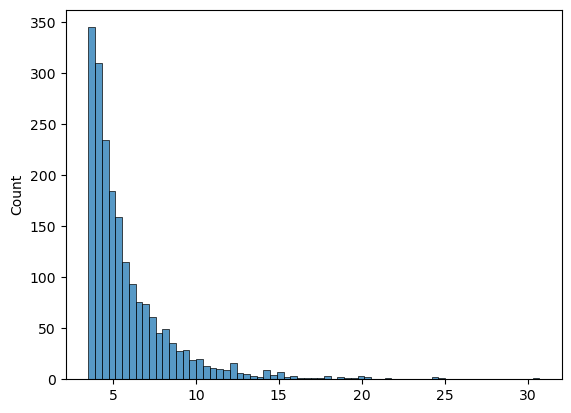

In [10]:
# sns.histplot(top_genes_var[:2000])

# Filter genes with SHAP values

In [11]:
X = X_train_var_genes
y = y_train_var_genes

folds_scores = []
folds_features = {}

selected_features = X.columns

while len(selected_features) > 3000:
    stratified_kfold_splitter = StratifiedKFold(n_splits=3, shuffle=True)

    fold_feature_scores = []

    for train_index, test_index in stratified_kfold_splitter.split(X, y):
        X_train, X_test = (
            X.iloc[train_index][selected_features],
            X.iloc[test_index][selected_features],
        )
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        X_train = X_train.rank(axis=1)
        X_test = X_test.rank(axis=1)

        params = {
            "learning_rate": [0.005, 0.1],
            "n_estimators": [40, 100, 300],
            "num_leaves": [6, 8, 12, 16],
            "colsample_bytree": [0.65, 0.66],
            "subsample": [0.7, 0.75],
            "reg_alpha": [1, 1.2],
            "reg_lambda": [1, 1.2, 1.4],
        }

        model = LGBMClassifier(n_jobs=4, verbose=-1)

        skf = StratifiedKFold(n_splits=5, shuffle=True)

        random_search = RandomizedSearchCV(
            model,
            param_distributions=params,
            n_iter=10,
            scoring="f1_weighted",
            n_jobs=4,
            cv=skf.split(X_train, y_train),
            verbose=0,
        )

        random_search.fit(X_train, y_train)

        best_params = random_search.best_params_

        model = LGBMClassifier(**best_params, n_jobs=4, verbose=-1)
        model.fit(X_train, y_train)

        model_score = f1_score(model.predict(X_test), y_test, average="macro")

        print("Model f1:", model_score)

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_train)

        fold_feature_score = pd.Series(
            -np.abs(shap_values).mean(0).mean(0), index=X_test.columns
        )

        folds_scores.append(
            {"n_features": len(selected_features), "f1_score": model_score}
        )

        fold_feature_scores.append(fold_feature_score)

    fold_feature_scores = pd.concat(fold_feature_scores, axis=1)
    fold_feature_scores = fold_feature_scores.mean(axis=1)

    fold_feature_scores = fold_feature_scores.sort_values()

    selected_features = fold_feature_scores.iloc[:-5].index

    folds_features[len(selected_features)] = list(fold_feature_scores.iloc[:-5].index)
    if selected_features.shape[0] % 100 == 0:
        print(f"How many features are selected: {selected_features.shape[0]}")

folds_scores = pd.DataFrame(folds_scores)

Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7923021060275962


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6822026050990802


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7662337662337662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.8181491464510333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6600179694519317


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414633


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8068292682926829


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8023360287511231


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078927956724859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7590531708178768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.773424089967446


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7746341463414633


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7923021060275962


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7780130800373715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.6793522267206478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6644880174291938


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7872023809523809


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496325


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7302681992337164


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737958


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6952944658182894


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7342684589908435


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806
How many features are selected: 9900


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6984999074016914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7122391778262224


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7214014352047278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033347506529793


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7137035819914559


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7053571428571429


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7687108886107634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7780130800373715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.749747219413549


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7903830273772471


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6889880952380953


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302681992337164


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7835145477737958


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7363721804511278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7799864189147478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.666826923076923


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6964415395787946


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6793522267206478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170731


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7799864189147478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7342684589908436


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8052618637816573


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7241209736906811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7163801820020222


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7385834109972041


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8214900417998525


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8096153846153846


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


How many features are selected: 9800
Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6780487804878048


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8507053991309007


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7674785883496325


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.773424089967446


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7568443117576065


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7506493506493507


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6895615992281252


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7102439024390244


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.814141414141414


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579328


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7799864189147478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7356695869837298


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7038961038961038


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579329


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7241209736906811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7322515212981744


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7094887757026976


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7203210272873194


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7673872180451127


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7639846743295019


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7901430842607313


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8023360287511231


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845843


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7506493506493506


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6895615992281252


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6872987912288162


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


How many features are selected: 9700


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.726546315477952


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7241209736906811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7962837212173591


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.6329625884732053


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7950800095533794


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8192749568426692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8181491464510333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7241209736906811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8046759396271086


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.737321353193029


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7144230769230768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7577981651376147


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6889880952380953


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579328


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579328


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7102439024390244


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877492


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.6778379665456278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8082788671023965


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7171717171717171


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275962


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535949


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7122391778262224


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142858


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7793169333651779


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.802336028751123


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8035597356985534


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494
How many features are selected: 9600


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7793169333651779


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7078927956724859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8125810235199704


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7124183006535949


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7022792022792022


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.6957957022734351


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033347506529795


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6964415395787944


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.773424089967446


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7194805194805195


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7911269999413937


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7163801820020222


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6729975227085053


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7435082140964493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7336182336182336


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7053571428571429


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182338


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7038961038961038


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7592906998679494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7662337662337662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7191489361702128


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.774598127539304


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7962837212173591


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7611905456667638


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.797979797979798


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.8000931966449208


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7203210272873194


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7026282853566959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7506493506493507


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.773424089967446


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


How many features are selected: 9500
Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6754364396360955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7435082140964494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414633


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515724


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.726089417091115


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877492


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7746341463414634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.6596868515374457


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.717948717948718


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7890500147972772


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7026282853566959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7687108886107634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.796283721217359


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737958


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7054815172164264


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.774598127539304


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031952


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6828224813924866


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579329


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7780130800373715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7765976072366501


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6761363636363636


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7577981651376147


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7109203906481207


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6329625884732053


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6916646176542907


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078927956724859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7577981651376147


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031952


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692
How many features are selected: 9400


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.695795702273435


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.760182851784563


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.6889880952380953


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7144230769230768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.796283721217359


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.6916646176542907


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579328


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7838596491228069


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.6931818181818181


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182338


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7214014352047278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7208646616541352


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302681992337166


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7684210526315789


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6864205457463883


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6895615992281252


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8266061619297826


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6442983897469603


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737958


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6762874929258631


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142858


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7944565555901588


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7701416299048061


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6866096866096867


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7878445145544378


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6964415395787944


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.797979797979798


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7920046688065363


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6804647785039941


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7053571428571429


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845843
How many features are selected: 9300


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033707865168539


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799298245614035


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717171


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6705120420967416


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7673872180451127


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7191489361702127


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7808429118773947


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.792778649921507


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7330637007077856


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7214014352047278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6964415395787944


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7203210272873194


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7241209736906811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7330637007077856


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6964415395787944


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.727963257375022


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579328


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579329


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6912280701754386


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8169209431345353


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078927956724859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7208646616541352


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.82030186445694


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6984999074016914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7435082140964493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6941463414634146


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6532123238595653


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7163801820020222


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.8068292682926829


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7673872180451127


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182338


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737958


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515723


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7068199634178207


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8096153846153846


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


How many features are selected: 9200
Model f1: 0.8035714285714285


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7214014352047278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846155


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7163801820020222


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7673872180451127


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7673872180451129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717171


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7356695869837296


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7984022556390977


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8125810235199704


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.691644204851752


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535949


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6694703049759231


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7590531708178767


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6458536585365854


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7736136695674267


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7026282853566959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6659053027964689


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7662337662337662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7330637007077856


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737958


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7662337662337662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737958


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033347506529795


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7793169333651779


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7191489361702128


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7850811071579328


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7911269999413937


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6663296258847321


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


How many features are selected: 9100
Model f1: 0.7492877492877493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6793522267206478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8125810235199704


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7350649350649351


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.773424089967446


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270716


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.796283721217359


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7447107777061477


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7577981651376147


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6952944658182894


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414633


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7342684589908436


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779956


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7529824561403509


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.6984999074016915


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6729975227085053


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8035597356985534


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877492


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7122391778262224


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.811965811965812


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6793522267206478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7687108886107634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7292387036277326


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.707457322551662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7109203906481207


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027
How many features are selected: 9000


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6964415395787944


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8155864666221222


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7565773297270716


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8017521902377973


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7506493506493506


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414633


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.717948717948718


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078927956724859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6754364396360953


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7010101010101011


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6748984889835585


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8220711480982242


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6985576923076922


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033347506529795


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.773424089967446


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7191489361702128


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6965517241379311


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7053571428571429


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7793169333651779


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6889880952380951


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6941463414634146


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7102439024390244


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515724


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7765976072366501


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7852315394242804


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.707457322551662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182336
How many features are selected: 8900


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7577981651376147


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.707457322551662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121367


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7435082140964493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8082788671023965


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8288783258225816


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6712628318046528


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7279632573750221


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7756549258629784


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7053571428571429


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6758310871518418


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7400749539477864


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7793169333651779


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7590531708178767


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6985576923076923


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846155


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6916442048517519


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033707865168539


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7054815172164264


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7590531708178768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182338


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7356695869837298


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7950800095533794


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6889880952380951


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.727963257375022


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7102272727272727


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6864205457463883


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.661951219512195


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579329


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.707457322551662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6628352490421455


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7054815172164264


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


How many features are selected: 8800
Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170731


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8035714285714285


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6758310871518418


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6826923076923077


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7053571428571429


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515724


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.701010101010101


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7026282853566959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.810843085741581


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7613636363636362


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6796934865900383


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7194805194805195


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.717124488603156


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7194805194805195


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.726546315477952


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7065362383281458


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.695795702273435


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6964415395787946


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7026282853566959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496325


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.717948717948718


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6689754000477669


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8068292682926829


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7674785883496325


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6694703049759231


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7756549258629784


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7241209736906811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031952


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


How many features are selected: 8700
Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6449122807017544


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078927956724859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6996966632962589


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.749747219413549


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8266061619297826


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7005015524241701


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6931818181818181


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7662337662337662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7950800095533794


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6532123238595653


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6931818181818181


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6872987912288162


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7038961038961038


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7065362383281458


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.703896103896104


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.717948717948718


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7162646286123717


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579328


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033707865168539


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6861076345431789


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515724


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.726089417091115


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737958


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.6872987912288162


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6502384737678855


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7974025974025974


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514124293785311


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7010101010101011


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6830131445904956


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8096153846153846


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779956


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6982945554709019
How many features are selected: 8600


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121367


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6984999074016914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7102439024390244


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7850811071579328


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6916646176542907


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7793169333651779


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.727963257375022


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6984999074016915


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7506493506493506


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515723


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6952944658182894


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.652701882210079


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6985576923076923


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7054815172164264


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7191489361702127


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7592906998679494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6866096866096867


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7102272727272727


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7092684088338592


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7506493506493507


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7109203906481207


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6952944658182894


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414633


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6796685409884582


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7684210526315789


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306
How many features are selected: 8500


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033347506529793


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7974025974025974


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6861076345431789


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7208646616541352


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7363721804511278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7054815172164264


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.811965811965812


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7092684088338592


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.717948717948718


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7977011494252874


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6793522267206478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515723


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6965517241379311


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7109203906481207


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182336


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7447107777061477


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6592082616179002


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6686868686868688


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7997977755308392


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6935531876897434


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8339622641509434


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779956


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7944565555901588


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7203210272873194


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.726089417091115


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806
How many features are selected: 8400


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7664307381193125


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033347506529795


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7162646286123716


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7484061781137037


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.774598127539304


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.774598127539304


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7346555883141249


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6552706552706553


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7997977755308392


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7684210526315789


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579329


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515724


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6796685409884582


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6815867059769498


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7793169333651779


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8023360287511231


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6872987912288162


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6889880952380951


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7780130800373715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7506493506493506


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7375438596491228


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7092684088338592


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8192749568426692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302681992337164


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7022792022792024


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.717948717948718


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737958


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496325


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.661951219512195


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.810843085741581


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6864205457463883


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7162646286123716


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078927956724859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7852315394242804


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717171


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


How many features are selected: 8300
Model f1: 0.7443718228031955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7447107777061477


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6883116883116883


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7613636363636362


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7292387036277325


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7662337662337662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579328


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7356695869837298


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6957957022734351


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7662337662337662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515724


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7687108886107634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6663296258847321


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7592906998679494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8056880409821586


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7447107777061477


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7664307381193125


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7780130800373715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6726190476190477


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7780130800373715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6847384762359685


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7687108886107634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275962


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6822026050990802


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7162646286123717


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7010101010101011


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8229268292682927


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7241209736906811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.797979797979798


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7793169333651779


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6964415395787946


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7272727272727273


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6985576923076923


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7806267806267806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7171717171717171
How many features are selected: 8200


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7214014352047278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170731


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6912280701754385


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7241209736906811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6866096866096867


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7026282853566959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7950800095533794


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8266061619297826


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6778379665456278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.695795702273435


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.664488017429194


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7435082140964493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779956


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.810843085741581


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515723


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.695795702273435


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8109000311429462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7529824561403509


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7005015524241701


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6758310871518419


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270716


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.726089417091115


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.774598127539304


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7568443117576067


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7443718228031955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515723


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7022792022792022


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7664307381193125


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395
How many features are selected: 8100


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6931818181818181


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.717948717948718


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.810843085741581


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7435082140964493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.723205964585275


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302681992337166


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7542215088282505


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7109203906481207


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078927956724859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7065362383281458


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7924919826447839


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6984999074016915


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7447107777061477


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.806829268292683


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.717948717948718


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779956


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.834990177986785


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.65625


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7094887757026976


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7577981651376147


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7350649350649352


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7233055961379662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6889880952380951


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7092684088338592


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7590531708178768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779956


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7026282853566959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7592906998679494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6628352490421456


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7394938472254469


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7134099616858238
How many features are selected: 8000


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7664307381193125


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7944565555901588


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6984999074016914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7088460645460877


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6848484848484848


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7233055961379662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182336


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.774598127539304


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7336182336182338


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6916646176542907


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7310548800525797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7662337662337662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7279632573750221


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.806829268292683


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6895615992281252


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.684155237817333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7053571428571429


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6712628318046528


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779956


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275962


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7375438596491228


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182338


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7890500147972773


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7435082140964494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6762874929258631


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8359277892867714


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7163801820020222


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8096153846153846


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


How many features are selected: 7900
Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6984999074016915


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7447107777061477


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515724


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7214014352047278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6793522267206478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6964415395787944


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7144230769230768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6509615384615386


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033347506529793


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033707865168539


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7144230769230768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7214014352047278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7758913412563667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7137666295493172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6726190476190477


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7292387036277326


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7163801820020222


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515724


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7330637007077856


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579328


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7375438596491228


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7054815172164264


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6985576923076923


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7303764225269915


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7673872180451129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6889880952380951


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7149693609571053


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7122391778262224


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6872987912288162


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182336


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


How many features are selected: 7800
Model f1: 0.7109203906481207


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6762874929258631


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7662337662337662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6931818181818182


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579328


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336101020584676


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7134099616858237


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7144230769230768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7363721804511278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7356695869837298


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7208646616541354


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8023360287511231


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535947


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7962962962962963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7685563997662186


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.6952944658182894


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7400749539477864


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535947


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7372712680577849


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7421722403077833


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7447107777061477


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.717948717948718


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7664307381193125


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535949


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7793169333651779


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8052618637816573


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7194805194805195


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7592906998679494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6996966632962589


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6916442048517519


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031952
How many features are selected: 7700


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7664307381193125


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7662337662337662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8096153846153846


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535949


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6712628318046528


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182336


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7144230769230768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.796283721217359


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7828947368421053


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717171


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6985576923076922


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7094887757026975


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7962962962962963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7662337662337662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7962962962962963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7102439024390244


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7194805194805195


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7026282853566959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7053571428571428


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033707865168539


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7214014352047278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6848484848484848


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6889880952380953


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6793522267206478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514124293785311


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7684210526315789


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078285181733457


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121367


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7022792022792024


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7109203906481207


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.82030186445694


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7026282853566959
How many features are selected: 7600


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515724


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7662337662337662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7313797313797313


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8108430857415811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6758310871518418


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737958


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6694703049759231


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.707457322551662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7265463154779521


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7950800095533794


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7780130800373715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535947


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7421722403077834


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6863517820921472


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7241209736906811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7911269999413937


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7793169333651779


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6996966632962589


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078927956724859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270716


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7194805194805196


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515724


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.783114256825076


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579328


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414633


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.723305596137966


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7984022556390977


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341
How many features are selected: 7500


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078927956724859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7241209736906811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7394938472254469


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7240658479226548


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7350649350649352


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7162646286123716


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6931818181818181


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6804647785039941


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7944565555901588


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7094887757026975


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8035714285714285


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7053571428571429


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7265463154779521


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7687108886107634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.783859649122807


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7122391778262224


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7022792022792024


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6754364396360953


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7214014352047278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121367


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7687108886107634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.8254807692307693


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.65625


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515724


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7780130800373715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7350649350649351


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7828947368421053


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8028443405415936


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7054815172164264
How many features are selected: 7400


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443181818181819


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.723305596137966


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7568443117576065


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7356695869837298


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7208646616541352


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515724


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7272727272727273


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Model f1: 0.7962962962962963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6941463414634146


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7163801820020222


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535947


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6984999074016914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7793169333651779


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6964415395787946


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8087510866415532


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7191489361702128


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779956


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737958


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6804647785039941


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7203210272873194


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8161133039238448


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6830131445904956


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8035714285714285


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.723305596137966


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182336


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7435082140964493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078927956724859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7092684088338592


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.726089417091115


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064
How many features are selected: 7300


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7799864189147478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7162646286123716


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7134099616858237


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6866096866096867


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6897668805183256


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8487607791111379


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7687108886107634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496325


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7592906998679494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7518796992481203


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7065362383281458


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.749747219413549


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.737321353193029


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.723305596137966


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6964415395787946


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182338


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7330637007077856


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7984022556390977


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7191489361702128


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6941463414634146


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078927956724859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7673872180451127


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7356695869837298


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7421722403077834


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6964415395787944


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302681992337164


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182336


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7162646286123716


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6996966632962589


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6864205457463883


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7780130800373715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7214014352047278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.703896103896104


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6826923076923077


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7350649350649352


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8242556281771968
How many features are selected: 7200


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182338


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7191489361702127


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7163801820020222


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7756549258629784


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6778379665456278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515723


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7950800095533794


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7214014352047278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7901430842607313


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7191489361702128


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717171


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6935531876897434


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7736136695674267


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7066666666666666


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275962


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.749747219413549


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7054815172164264


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8199404761904763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7005015524241701


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.806599074019809


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7400749539477864


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7038961038961038


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7799864189147478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7673872180451129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6984999074016914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7265463154779521


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


How many features are selected: 7100
Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6796934865900383


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078927956724859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414633


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.726546315477952


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7421722403077834


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182338


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.723305596137966


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7402777777777778


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6350961538461539


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443181818181819


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7203210272873194


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8035597356985534


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8108430857415811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7137666295493172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078927956724859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7687108886107634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6629087511678605


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7322515212981744


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846155


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6600179694519317


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7162646286123716


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.82030186445694


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7793169333651779


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7191489361702127


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6872987912288162


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7330637007077856


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7279632573750221


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7356695869837298


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.717124488603156


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7673872180451127


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7372712680577849


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7265463154779521
How many features are selected: 7000


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7109203906481207


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7852315394242804


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7878445145544378


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7447107777061477


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7053571428571428


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7092684088338592


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7944565555901588


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7265463154779521


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.774598127539304


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8229268292682927


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6968733439321674


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170731


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6984999074016914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7363721804511276


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7687108886107634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7054815172164264


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7144230769230768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7005015524241701


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515724


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7687108886107634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7054815172164264


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8125810235199704


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8035597356985534


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579328


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8052618637816573


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7137666295493172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7901430842607313


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033347506529793


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033347506529795


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8125810235199704


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6659053027964689


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732
How many features are selected: 6900


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6813283872107401


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.70050155242417


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7214014352047278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7471264367816093


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6895615992281252


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7592906998679494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7350649350649352


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845843


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7094887757026976


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7529824561403509


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7054815172164264


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7214014352047278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7592906998679494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7780130800373715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7221052631578948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7592906998679494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7529824561403509


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7053571428571428


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7780130800373715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7203210272873194


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6941463414634146


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6796934865900383


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7026282853566959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.738583410997204


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.737321353193029


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8096153846153846


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182338


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7191489361702128
How many features are selected: 6800


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6793522267206478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515723


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7920046688065363


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7144230769230768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121367


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7568443117576065


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7356695869837298


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6847384762359685


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.726089417091115


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181819


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7109203906481207


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7684210526315789


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.749747219413549


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6619512195121953


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.726546315477952


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7191489361702128


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515724


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6935531876897434


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7206349206349207


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7054815172164264


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7094887757026976


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6984999074016914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7920046688065363


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6984999074016914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.814141414141414


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6889880952380953


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6552268723804896


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7687108886107634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6629087511678605


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6778379665456278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8242556281771969


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7053571428571428
How many features are selected: 6700


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7662337662337662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033707865168539


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515724


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7122391778262224


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6790009858692081


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7920046688065363


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7506493506493507


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7265463154779521


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.783859649122807


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275962


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.666329625884732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.707457322551662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6830131445904956


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.806599074019809


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7149693609571053


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7241209736906811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7144230769230768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8046759396271086


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7435082140964493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7799864189147478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6941463414634146


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7134099616858237


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7279632573750221


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7684210526315789


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.749747219413549


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.707457322551662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142858


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7400749539477864


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7673872180451127


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7662337662337662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737958


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7094887757026975


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515723


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8082788671023966


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7303764225269915


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6866096866096867


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078927956724859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7568443117576067


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7518796992481203


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306
How many features are selected: 6600


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8316224260462857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515723


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6861076345431789


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6898496240601504


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7194805194805196


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7303764225269915


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7214014352047278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8035714285714286


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.726089417091115


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8212329977035859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078927956724859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7847157502329916


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6804647785039941


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8082788671023966


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7592906998679494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6758310871518418


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7094887757026976


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6780487804878048


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7673872180451129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182338


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7272727272727273


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.726546315477952


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6628352490421456


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270716


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6673504073140714


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6590909090909091


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7577981651376147


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6889880952380953


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7577981651376147


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6883116883116883


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8082788671023966


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7109203906481207


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515723


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381
How many features are selected: 6500


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6847384762359685


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270716


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6848484848484848


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7950800095533794


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877492


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182338


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7852315394242804


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7590531708178767


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7878445145544378


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7122391778262224


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7950800095533794


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535949


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7265463154779521


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078927956724859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182336


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182338


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.726089417091115


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6861076345431789


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.792491982644784


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.774598127539304


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7134099616858237


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6999805182154686


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8192749568426692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7350649350649351


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7611905456667638


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7241209736906811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7793169333651779
How many features are selected: 6400


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7022792022792022


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7878445145544378


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.749747219413549


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7421722403077833


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8551219512195122


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6813283872107403


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7191489361702128


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7137666295493172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7687108886107634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737958


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6964415395787944


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6847384762359685


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443181818181819


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7356695869837298


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6780487804878048


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.726089417091115


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7457834840968778


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033347506529795


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8242556281771969


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7356695869837298


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6592082616179002


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7577981651376147


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515724


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6965517241379311


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7974025974025976


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7330637007077856


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7765976072366501


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7356695869837298


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.695795702273435


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121367


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7808429118773947


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7265463154779521


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7711717495987158


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7137666295493172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.717948717948718


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6754364396360955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8035597356985534
How many features are selected: 6300


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579328


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7736136695674267


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6935221732064081


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8155864666221222


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.749747219413549


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.774598127539304


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535949


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799298245614035


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.737321353193029


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7022792022792022


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7592906998679494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7241209736906811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270716


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579328


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6872987912288162


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.662122745401512


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7872023809523809


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6847384762359685


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8266061619297826


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7350649350649352


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7163801820020222


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7330637007077856


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7799864189147478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6686868686868687


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7765976072366501


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7838596491228069


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.723305596137966


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181819


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6895615992281252


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033707865168539


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7577981651376147


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.717948717948718


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7163801820020222


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7053571428571429


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8035597356985534
How many features are selected: 6200


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7808429118773947


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7950800095533794


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8155864666221224


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.727963257375022


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7808429118773947


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8046759396271086


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7356695869837298


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7094887757026975


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6985576923076923


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8328408611228366


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7005015524241701


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8082788671023966


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.726089417091115


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7363721804511278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7799864189147478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7799864189147478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.774598127539304


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.717948717948718


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8389727126805779


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7950800095533794


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7793169333651779


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7421722403077834


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.727963257375022


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7026282853566959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737958


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717171


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6723281944081525


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033347506529795


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7279632573750221


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7506493506493506


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6964415395787944


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7194805194805196


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7194805194805196


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7122391778262224


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.723305596137966


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779956
How many features are selected: 6100


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7577981651376147


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6985576923076923


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7435082140964494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7962962962962963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7799864189147478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7577981651376147


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7592906998679494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7137666295493172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7793169333651779


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414633


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8129870129870129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7054815172164264


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7122391778262224


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7137666295493172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7568443117576065


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7780130800373715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7435082140964493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7068199634178207


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7758913412563667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7356695869837296


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182336


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7054815172164264


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8169209431345353


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7214014352047278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7102272727272727


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7191489361702127


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182336


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6931818181818181


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7756549258629784


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6968733439321674


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270716


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275962


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6985576923076923


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7163801820020222


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7974025974025976
How many features are selected: 6000


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7330637007077856


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7518796992481203


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7758913412563667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.726089417091115


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7878445145544378


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7214014352047278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579328


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.774598127539304


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7372712680577849


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7962962962962963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7162646286123717


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7102439024390244


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7828947368421053


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.717124488603156


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033347506529793


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7094887757026976


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275962


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.796283721217359


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7962962962962963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6872987912288162


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8035714285714286


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7102439024390244


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182338


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6712628318046528


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.749747219413549


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8035714285714285


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7054815172164264


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7203210272873194


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8276353276353277


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7780130800373715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6916442048517519


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7684210526315789


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6895615992281252


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7053571428571429


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7265463154779521
How many features are selected: 5900


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579329


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7363721804511276


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.749747219413549


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7673872180451129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.717948717948718


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779956


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6826923076923077


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7974025974025976


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7693383038210624


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6928881343142803


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033347506529795


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7878445145544378


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6780487804878048


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7109203906481207


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6883116883116883


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7350649350649352


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6780487804878048


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121367


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7662337662337662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7241209736906811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6656925774400935


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7529824561403509


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7518796992481203


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7400749539477864


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7984022556390977


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7793169333651779


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078927956724859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8052618637816573


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7214014352047278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7962962962962963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7878445145544378


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7356695869837298


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6916646176542907


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7421722403077834
How many features are selected: 5800


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078927956724859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7122391778262224


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7330637007077856


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302681992337164


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7265463154779521


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7279632573750221


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7568443117576065


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6985576923076923


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7950800095533794


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7950800095533794


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.726546315477952


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7568443117576067


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7903830273772471


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6793522267206478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7421722403077834


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7903830273772471


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182338


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7878445145544378


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078927956724859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535947


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579328


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7684210526315789


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7094887757026976


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6957957022734351


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7144230769230768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7962962962962963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6984999074016914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8068292682926829


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7054815172164264


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303
How many features are selected: 5700


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6804647785039941


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7950800095533794


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.814141414141414


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7878445145544378


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515724


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7065362383281459


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8035597356985534


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6258819272749201


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7375438596491228


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877492


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7372712680577849


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.834990177986785


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7518796992481203


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7356695869837298


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846155


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7756549258629784


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6754364396360953


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7330637007077856


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6952944658182894


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7685563997662186


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6780487804878048


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737958


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7122391778262224


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7799864189147478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8023360287511231


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031952


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7852315394242804


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7662337662337662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302681992337166


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7102439024390244


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170731


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7878445145544378


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.664488017429194


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7010101010101011


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7506493506493506


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537
How many features are selected: 5600


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302681992337164


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.783859649122807


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6754364396360955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7890500147972772


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579329


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.717124488603156


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6391909129563262


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6864205457463883


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877492


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6941463414634146


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7010101010101011


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7950800095533794


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7838596491228069


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7233055961379662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7144230769230768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7214014352047278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7372712680577849


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7330637007077856


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7950800095533794


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8169209431345354


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.774598127539304


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7711717495987158


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7542215088282505


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7518796992481203


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6895615992281252


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535949


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7765976072366501


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6872987912288162


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877492


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341
How many features are selected: 5500


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7831142568250757


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7313797313797314


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8169209431345354


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6709401709401709


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7529824561403509


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7102439024390244


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.82030186445694


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6984999074016915


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8285714285714286


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302681992337164


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6780487804878048


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7194805194805196


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031952


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7421722403077833


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8303030303030302


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8046759396271086


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8068292682926829


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6941463414634146


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8108430857415811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7662337662337662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.717948717948718


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.796283721217359


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7974025974025974


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6996966632962589
How many features are selected: 5400


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7421722403077834


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7400749539477864


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8017521902377973


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7094887757026975


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7793169333651779


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.723205964585275


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6780487804878048


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6895615992281252


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121367


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7592906998679494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8181491464510333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.726089417091115


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.737321353193029


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8229268292682927


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7780130800373715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535947


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7684210526315789


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8181491464510333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7687108886107634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7054815172164264


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7962962962962963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7872023809523809


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7053571428571428


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6267519055815096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7471264367816093


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7628513474355259


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6984999074016914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7038961038961038


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078927956724859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845843


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.760182851784563


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877492


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7214014352047278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8141414141414142


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7092684088338592


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8266061619297826


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8082788671023965
How many features are selected: 5300


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8017521902377973


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7447107777061477


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6758310871518419


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8052618637816573


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6916442048517519


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6985576923076922


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7977011494252874


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.797979797979798


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275962


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7054815172164264


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7162646286123716


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.695795702273435


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496325


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.797979797979798


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.717124488603156


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6968733439321675


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7799864189147478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6982945554709019


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7092684088338592


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.774598127539304


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.749747219413549
How many features are selected: 5200


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.760182851784563


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033347506529793


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7852315394242804


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.666826923076923


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7590531708178768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.737321353193029


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7577981651376147


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275962


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877492


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7944565555901588


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7094887757026976


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7292387036277325


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7137666295493172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7102439024390244


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8108430857415811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7214014352047278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121367


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7163801820020222


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8303030303030302


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6577217632515227


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033347506529795


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7950800095533794


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737958


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6982945554709019


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7506493506493506


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6984999074016915


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8023360287511231


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7279632573750221


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7577981651376147


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7350649350649351


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6952944658182894


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7241209736906811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8108430857415811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7662337662337662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579329
How many features are selected: 5100


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7662337662337662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.723305596137966


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.726089417091115


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6941463414634146


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7214014352047278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7208646616541352


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.723305596137966


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7872023809523809


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7194805194805196


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8082788671023965


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031952


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7363721804511276


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7758913412563667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8441558441558441


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.797979797979798


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.774598127539304


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7241209736906811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270716


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7950800095533794


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.707457322551662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6813283872107401


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.783859649122807


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7350649350649351


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7539608574091332


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7054815172164264


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579328


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7758913412563667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8096153846153846


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.773424089967446


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033347506529795


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8169209431345354


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8108430857415811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.737321353193029


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7162646286123717
How many features are selected: 5000


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302681992337164


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7577981651376147


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7363721804511276


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7092684088338592


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.749747219413549


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8199404761904763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.65625


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.773424089967446


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6761363636363636


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7241209736906811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.811965811965812


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7272727272727273


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7756549258629784


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7394938472254469


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7010101010101011


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7673872180451127


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7356695869837298


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.773424089967446


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6629087511678605


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6916646176542907


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7799864189147478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7962962962962963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.773424089967446


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7363721804511278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031952


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6712628318046528


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7109203906481207


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.727963257375022


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462
How many features are selected: 4900


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7577981651376147


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7435082140964494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8254807692307692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737958


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515723


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6588345864661653


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8082788671023966


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7828947368421053


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7758913412563667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.701010101010101


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7144230769230768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170731


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7506493506493506


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7208646616541354


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7780130800373715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7774289202860631


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535949


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7102439024390244


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8254807692307693


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8169209431345353


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737958


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.703896103896104


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6965517241379311


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7054815172164264


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7878445145544378


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275962


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.662122745401512


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.834990177986785


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8052618637816573


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7577981651376147
How many features are selected: 4800


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7026282853566959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7372712680577849


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7793169333651779


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7890500147972773


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7303764225269915


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7356695869837298


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.703896103896104


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414633


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7092684088338592


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8052618637816573


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414633


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8023360287511231


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7878445145544378


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7467294610151753


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7191489361702128


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7102272727272727


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7601828517845631


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.726089417091115


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.774598127539304


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7350649350649351


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7984022556390977


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.726546315477952


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7471264367816093


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717171


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078927956724859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877492


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8141414141414142


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779956
How many features are selected: 4700


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515724


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.797979797979798


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275962


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779956


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.773424089967446


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8017521902377973


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7529824561403509


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846155


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.774598127539304


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8276353276353277


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8169209431345353


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7911269999413937


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6889880952380951


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7279632573750221


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275962


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846155


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7831142568250757


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7163801820020222


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8212329977035859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7122391778262224


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7984022556390977


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6796685409884581


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7191489361702127


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.796283721217359


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7137666295493172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496325


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8082788671023966


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.707457322551662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7162646286123716


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8266061619297826


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7687108886107634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.726089417091115


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7350649350649352


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7878445145544378


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6804647785039941


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7590531708178768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579329
How many features are selected: 4600


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7838596491228069


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7974025974025974


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7122391778262224


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.783859649122807


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877492


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6729975227085053


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8035597356985534


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579329


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7026282853566959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7054815172164264


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7687108886107634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7590531708178767


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8023360287511231


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7217261904761905


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.726089417091115


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8339622641509434


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.806829268292683


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7799864189147478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7890500147972772


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7272727272727273


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7054815172164264


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7542215088282505


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7421722403077833


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033347506529795


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7457834840968778


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7799864189147478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8023360287511231


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6525252525252525


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031952


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7962962962962963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494
How many features are selected: 4500


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7162646286123716


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.797979797979798


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.761190545666764


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7109203906481207


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7053571428571429


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8108430857415811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8169209431345353


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7330637007077856


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8199404761904763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.707457322551662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7265463154779521


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6984999074016914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8423692381179843


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7265463154779521


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7611905456667638


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6889880952380953


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6952944658182894


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8052618637816573


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181819


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031952


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275962


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078927956724859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7662337662337662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8141414141414142


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.701010101010101


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8082788671023966


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6723281944081525


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6965517241379311


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.834990177986785
How many features are selected: 4400


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078285181733457


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7673872180451127


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7518796992481203


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.726089417091115


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7611905456667638


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845843


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6780487804878048


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8035597356985534


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8035597356985534


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6935531876897434


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170731


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7974025974025976


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182338


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7163801820020222


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7272727272727273


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7506493506493506


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7592906998679494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6592082616179002


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7518796992481203


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033347506529793


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7793169333651779


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7701416299048061


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8192749568426692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7944565555901588


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8155864666221224


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7350649350649352


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.796283721217359


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6826923076923076


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8068292682926829


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8328408611228366


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8581323143061859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8169209431345353


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914
How many features are selected: 4300


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7736136695674267


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.811965811965812


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7010101010101011


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7053571428571428


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.811965811965812


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8046759396271086


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182338


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579328


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7467294610151753


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7435082140964493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8422939068100359


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7109203906481207


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8082788671023965


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7421722403077833


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8402323892519972


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7109203906481207


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8242556281771969


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7435082140964493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779956


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7122391778262224


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7878445145544378


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7102439024390244


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8266061619297826


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6897668805183256


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6847384762359685


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8192749568426692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.737321353193029


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7109203906481207


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779956


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7350649350649352


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275962


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7162646286123716


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535949
How many features are selected: 4200


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.797979797979798


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182338


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7662337662337662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8254807692307692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6828224813924866


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8023360287511231


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8052618637816573


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7684210526315789


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7144230769230768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717171


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7577981651376147


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.723305596137966


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142858


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6964415395787944


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7793169333651779


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7687108886107634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535949


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6780487804878048


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7241209736906811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.760182851784563


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.737321353193029


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7330637007077856


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8610526315789473


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182336


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7673872180451129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535949


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8214900417998525


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8797303043187754


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033347506529795


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7054815172164264
How many features are selected: 4100


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7872023809523809


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7265463154779521


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496325


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.726089417091115


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7241209736906811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7372712680577849


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7577981651376147


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496325


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.773424089967446


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7203210272873194


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535949


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799298245614035


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7962962962962963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737958


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7144230769230768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8328408611228366


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7356695869837298


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8052618637816573


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579329


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579328


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7950800095533794


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7144230769230768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7878445145544378


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8068292682926829


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.749747219413549


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7756549258629784


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8181491464510333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7241209736906811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7214014352047278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579329


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620791906506192


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7758913412563667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6726190476190477


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8052618637816573


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7664307381193125


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8082788671023966


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748
How many features are selected: 4000


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7208646616541352


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7467294610151753


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7808429118773947


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078927956724859


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737958


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7421722403077833


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.834990177986785


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7974025974025976


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7799864189147478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7094887757026975


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7611905456667638


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7852315394242804


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7506493506493506


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7272727272727273


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7962962962962963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7144230769230768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7265463154779521


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7799864189147478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7241209736906811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8192749568426692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.773424089967446


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8507053991309007


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7962962962962963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846155


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7053571428571429


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7592906998679494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7756549258629784


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7592906998679494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.774598127539304


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737958


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7756549258629784


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7687108886107634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8082788671023965


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6916442048517519


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7356695869837298


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8139097744360901
How many features are selected: 3900


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8301754385964912


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8090926240332013


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.806599074019809


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7162646286123716


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8082788671023966


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7852315394242804


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270716


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7241209736906811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7160300017442875


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8181491464510333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7780130800373715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.82030186445694


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8199404761904763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.810843085741581


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7518796992481203


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.707457322551662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7780130800373715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275962


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846155


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.797979797979798


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7162646286123717


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7758913412563667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.701010101010101


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7026282853566959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.701010101010101


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8402323892519972


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6968733439321674


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7780130800373715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121367


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6778379665456278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7421722403077833


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.797979797979798


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7094887757026976


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496325


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7068199634178207


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7838596491228069
How many features are selected: 3800


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033707865168539


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7169516082294987


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7144230769230768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.774598127539304


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7944565555901588


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8169209431345353


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7447107777061477


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8192749568426692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6552706552706553


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8423692381179843


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7356695869837298


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7482517482517483


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7878445145544378


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8109000311429462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033347506529793


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7053571428571429


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8052618637816573


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6866096866096867


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7793169333651779


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8141414141414142


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7920046688065363


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7435082140964493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.707457322551662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7852315394242804


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8242556281771969


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.749747219413549


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7385834109972041


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8316224260462857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7872023809523809


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7793169333651779


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8214900417998525


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6778379665456278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7144230769230768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7521902377972465


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7590531708178768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7375438596491228


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414633


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8487607791111379


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7144230769230768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8082788671023966


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8254807692307692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.669470304975923
How many features are selected: 3700


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8181491464510333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7890500147972772


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7950800095533794


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7053571428571428


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7662337662337662


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8108430857415811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6864205457463883


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579329


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7920046688065363


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.776325344952796


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.717948717948718


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6872987912288162


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7350649350649352


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8017521902377973


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033347506529795


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7539608574091332


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.797979797979798


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033347506529795


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.726089417091115


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7435082140964493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6552268723804896


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8288783258225816


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779956


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7592906998679494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7054815172164264


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496325


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8141414141414142


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.811965811965812


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7053571428571428


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7872023809523809


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6663296258847321


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8285714285714285


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7962962962962963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737958


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667
How many features are selected: 3600


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121365


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7518796992481203


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7506493506493506


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7799864189147478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8141414141414142


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7835145477737958


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846155


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6952944658182894


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6984999074016914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.806599074019809


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.772129293410322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8139097744360901


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7635538571769763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.811965811965812


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7191489361702127


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7194805194805196


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8229268292682927


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8423692381179843


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7911269999413937


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.802336028751123


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8074117303764226


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8161133039238448


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7094887757026976


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8155864666221224


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7852315394242804


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7144230769230768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779956


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8046759396271086


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7241209736906811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8056880409821586


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7053571428571429


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7793169333651779


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182336
How many features are selected: 3500


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7320277048005732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7592906998679494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7162646286123716


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7780130800373715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6985576923076923


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7162646286123717


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7890500147972773


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.727963257375022


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8125810235199704


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7962962962962963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7163801820020222


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.773424089967446


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142858


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8096153846153846


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.737321353193029


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.79375


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.717948717948718


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7911269999413937


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7147972097043027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.738095238095238


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7901430842607313


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6813283872107403


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7421722403077833


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8035597356985534


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6985576923076922


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8108430857415811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7102439024390244


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7639846743295019


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.727963257375022


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846155


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7518796992481203


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.737321353193029


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7890500147972773


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7162646286123716


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8181491464510333
How many features are selected: 3400


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.773424089967446


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7542215088282505


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7406988511220906


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6895615992281252


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8082788671023966


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.737321353193029


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877493


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6931818181818181


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7390835579514825


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7208646616541352


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7793169333651779


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414634


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579328


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7542215088282505


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6985576923076923


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8035597356985534


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7249836299779748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7171717171717172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7852315394242804


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.717948717948718


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8052618637816573


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7780130800373715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7890500147972773


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8068292682926829


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7403491517088763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121367


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8023360287511231


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7092684088338592


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7102439024390244


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877492


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.773424089967446


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7997977755308392


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8023360287511231


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.728395061728395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8096153846153846


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877492


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8242556281771969


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7033347506529793
How many features are selected: 3300


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6872987912288162


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7532412711813303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7649572649572649


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.691644204851752


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7684210526315789


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7590531708178767


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8254807692307693


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181819


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8145593869731801


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.82030186445694


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7333333333333334


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443181818181819


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7109203906481207


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515724


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7250000000000001


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7542215088282505


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7053571428571428


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7447107777061477


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7664307381193125


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7078285181733457


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7426900584795322


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.745126128931797


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6861076345431789


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182336


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7336182336182338


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7603485838779956


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7590531708178768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7421722403077834


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7907317073170732


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7806267806267806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8125810235199704


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7375438596491228


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7350649350649352


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7585365853658537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7950800095533794


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6984999074016914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7799864189147478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7065362383281459


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8056880409821586


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7424390243902439
How many features are selected: 3200


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8090926240332013


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8068292682926829


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.814141414141414


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7852315394242804


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8035597356985534


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8199404761904763


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7473918143095253


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7974025974025976


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275962


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7214014352047278


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7592906998679494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7878445145544378


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7799864189147478


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8192749568426692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8023360287511231


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6866096866096867


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8413461538461537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7684210526315789


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7565773297270716


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6964415395787944


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7590531708178768


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7636891166121367


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7780130800373715


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7611905456667638


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8285714285714286


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031952


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7850811071579328


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8276353276353277


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7124183006535948


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7615696044845842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181819


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7656565656565657


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7506493506493507


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6992763334226748


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7539608574091332


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7923021060275962


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8441558441558441


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142858


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7191489361702127


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8181491464510333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7477907809887747


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8359277892867714


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.6780487804878048


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7134099616858238
How many features are selected: 3100


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.797979797979798


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7590531708178767


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7373213531930289


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7950800095533794


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.796283721217359


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799298245614035


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7728055077452667


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8000931966449208


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8010010251462341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7577981651376147


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7708333333333333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7435082140964494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7263414634146341


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8359277892867714


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8052618637816573


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7890500147972772


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.799550507197959


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7350649350649352


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.731094512006914


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7443718228031955


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7707097933513027


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7620192307692308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7564140722662064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548966756513926


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7435082140964494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7778846153846154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7010101010101011


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7380952380952381


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8181491464510333


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7461538461538462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7302884615384615


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7514426289254692


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7241209736906811


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8129870129870129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.789033685763462


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7232704402515723


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7818181818181817


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7674785883496327


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7746341463414633


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8303030303030303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.666826923076923


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7494949494949494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.723305596137966


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7544642857142857


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7548177385651265


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.8363095238095238


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7691611891696315


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7492877492877492


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.82030186445694


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7193707100771427


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.664488017429194


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7865229110512129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.735406669501306


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Model f1: 0.7286826533790096
How many features are selected: 3000


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [15]:
pd.Series(selected_features).to_csv("data/tables/selected_genes.csv")

# Make dataframe with selected genes

In [12]:
selected_features = pd.read_csv("data/tables/selected_genes.csv")
selected_features = selected_features['0']
X = X[selected_features]
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Pycaret

In [31]:
from pycaret.classification import ClassificationExperiment

exp = ClassificationExperiment()

In [32]:
s = pycaret.classification.setup(X_train, target=y_train, session_id=123)

In [33]:
s.compare_models()

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [37]:
results = s.pull()

In [38]:
results

Model  Accuracy     AUC  Recall   Prec.  \
lightgbm  Light Gradient Boosting Machine    0.7073  0.7924  0.7879  0.7497   
gbc          Gradient Boosting Classifier    0.7071  0.7858  0.8062  0.7340   
rf               Random Forest Classifier    0.6716  0.6807  0.8371  0.6856   
ada                  Ada Boost Classifier    0.6679  0.7225  0.7515  0.7129   
dt               Decision Tree Classifier    0.6570  0.6410  0.7206  0.7087   
lda          Linear Discriminant Analysis    0.6566  0.6953  0.7449  0.7013   
et                 Extra Trees Classifier    0.6427  0.6889  0.7949  0.6689   
nb                            Naive Bayes    0.6243  0.6720  0.6132  0.7221   
knn                K Neighbors Classifier    0.6107  0.6350  0.6239  0.6860   
dummy                    Dummy Classifier    0.5956  0.5000  1.0000  0.5956   
svm                   SVM - Linear Kernel    0.5952  0.0000  0.6618  0.6936   
qda       Quadratic Discriminant Analysis    0.5952  0.6015  0.5621  0.7063   
lr                    Logistic Regression    0.5738  0.5855  0.6555  0.6411   
ridge                    Ridge Classifier    0.5524  0.0000  0.6129  0.6306   

              F1   Kappa     MCC  TT (Sec)  
lightgbm  0.7637  0.3765  0.3847    79.643  
gbc       0.7667  0.3738  0.3794     2.429  
rf        0.7526  0.2779  0.2921     0.249  
ada       0.7301  0.2959  0.2985     0.563  
dt        0.7134  0.2834  0.2848     0.366  
lda       0.7201  0.2742  0.2782     0.104  
et        0.7251  0.2233  0.2336     0.151  
nb        0.6599  0.2446  0.2519     0.310  
knn       0.6494  0.2114  0.2143     0.283  
dummy     0.7465  0.0000  0.0000     0.220  
svm       0.6374  0.1530  0.1861     0.289  
qda       0.6207  0.1932  0.2033     0.081  
lr        0.6457  0.1093  0.1106     0.548  
ridge     0.6192  0.0742  0.0751     0.054

# OPTUNA

In [50]:
class Objective(object):
    def __init__(self, X_data, y_data, multilabel_data):
        self.X_data = X_data
        self.y_data = y_data
        self.multilabel_data = multilabel_data

    def __call__(self, trial):
        params = {
            "class_weight": "balanced",
            "objective": "binary",
            "verbosity": -1,
            "n_jobs": 2,
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 9),
            "n_estimators": trial.suggest_int("n_estimators", 50, 2500),  # n_trees
            "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
            "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
            "feature_fraction": trial.suggest_uniform("feature_fraction", 0.05, 1.0),
            "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.05, 1.0),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 5000),
            "max_depth": trial.suggest_int("max_depth", 3, 13),
            "learning_rate": trial.suggest_uniform("learning_rate", 0.001, 0.3),
        }

        params["num_leaves"] = 2 ** params["max_depth"]

        mskf = StratifiedKFold(
            n_splits=5,
            shuffle=True,
            #             test_size=0.25,
            random_state=0,
        )

        result = []
        for train_index, test_index in mskf.split(self.X_data, self.multilabel_data):
            X_train, X_test = (
                self.X_data.iloc[train_index, :],
                self.X_data.iloc[test_index, :],
            )
            y_train, y_test = (
                self.y_data.iloc[train_index],
                self.y_data.iloc[test_index],
            )

            model = LGBMClassifier(**params)

            model.fit(X_train.astype(float), y_train)

            y_pred = model.predict(X_test)

            f1_val = f1_score(y_test, y_pred, average="weighted")

            result.append(f1_val)

        return np.mean(result)

In [51]:
import warnings

warnings.filterwarnings("ignore")

objective_p = Objective(
    X_train_var_genes[selected_features].rank(axis=1),
    y_train_var_genes,
    y_train_var_genes,
)
study_p = optuna.create_study(direction="maximize")

study_p.optimize(objective_p, n_trials=500, n_jobs=15)
print(study_p.best_trial)

NameError: name 'selected_features' is not defined

In [28]:
# study_p.best_params
best_params = {
    "bagging_freq": 4,
    "n_estimators": 485,
    "lambda_l1": 0.001006797248810902,
    "lambda_l2": 0.00016524747455300327,
    "feature_fraction": 0.7141450851253092,
    "bagging_fraction": 0.7847641253447116,
    "min_child_samples": 8,
    "max_depth": 5,
    "learning_rate": 0.11107633105791784,
}
best_params["num_leaves"] = 2 ** best_params["max_depth"]

In [31]:
best_model = LGBMClassifier(**best_params)
best_model.fit(X_train_var_genes[selected_features], y_train_var_genes)

y_train_predict = best_model.predict(X_train_var_genes[selected_features])
y_test_predict = best_model.predict(X_test_var_genes[selected_features])

print(f"train {classification_report(y_train_var_genes, y_train_predict)}")
print(f"test {classification_report(y_test_var_genes, y_test_predict)}")

[LightGBM] [Warning] feature_fraction is set=0.7141450851253092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7141450851253092
[LightGBM] [Warning] lambda_l2 is set=0.00016524747455300327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016524747455300327
[LightGBM] [Warning] lambda_l1 is set=0.001006797248810902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001006797248810902
[LightGBM] [Warning] bagging_fraction is set=0.7847641253447116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7847641253447116
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7141450851253092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7141450851253092
[LightGBM] [Warning] lambda_l2 is set=0.00016524747455300327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016524747455300327
[LightGBM] [Warn

In [30]:
best_model = LGBMClassifier(**best_params)
best_model.fit(X_train_var_genes[selected_features].rank(axis=1), y_train_var_genes)

y_train_predict = best_model.predict(X_train_var_genes[selected_features].rank(axis=1))
y_test_predict = best_model.predict(X_test_var_genes[selected_features].rank(axis=1))

print(f"train {classification_report(y_train_var_genes, y_train_predict)}")
print(f"test {classification_report(y_test_var_genes, y_test_predict)}")

[LightGBM] [Warning] feature_fraction is set=0.7141450851253092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7141450851253092
[LightGBM] [Warning] lambda_l2 is set=0.00016524747455300327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016524747455300327
[LightGBM] [Warning] lambda_l1 is set=0.001006797248810902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001006797248810902
[LightGBM] [Warning] bagging_fraction is set=0.7847641253447116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7847641253447116
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7141450851253092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7141450851253092
[LightGBM] [Warning] lambda_l2 is set=0.00016524747455300327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016524747455300327
[LightGBM] [Warn

In [33]:
best_model = LGBMClassifier()
best_model.fit(X_train_var_genes[selected_features], y_train_var_genes)

y_train_predict = best_model.predict(X_train_var_genes[selected_features])
y_test_predict = best_model.predict(X_test_var_genes[selected_features])

print(f"train {classification_report(y_train_var_genes, y_train_predict)}")
print(f"test {classification_report(y_test_var_genes, y_test_predict)}")

[LightGBM] [Info] Number of positive: 236, number of negative: 160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16704
[LightGBM] [Info] Number of data points in the train set: 396, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.595960 -> initscore=0.388658
[LightGBM] [Info] Start training from score 0.388658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [ ]:
best_model = LGBMClassifier()
best_model.fit(X_train_var_genes[selected_features], y_train_var_genes)

y_train_predict = best_model.predict(X_train_var_genes[selected_features])
y_test_predict = best_model.predict(X_test_var_genes[selected_features])

print(f"train {classification_report(y_train_var_genes, y_train_predict)}")
print(f"test {classification_report(y_test_var_genes, y_test_predict)}")

[LightGBM] [Info] Number of positive: 236, number of negative: 160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16704
[LightGBM] [Info] Number of data points in the train set: 396, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.595960 -> initscore=0.388658
[LightGBM] [Info] Start training from score 0.388658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [ ]:
best_model = LGBMClassifier()
best_model.fit(X_train_var_genes[selected_features], y_train_var_genes)

y_train_predict = best_model.predict(X_train_var_genes[selected_features])
y_test_predict = best_model.predict(X_test_var_genes[selected_features])

print(f"train {classification_report(y_train_var_genes, y_train_predict)}")
print(f"test {classification_report(y_test_var_genes, y_test_predict)}")

[LightGBM] [Info] Number of positive: 236, number of negative: 160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16704
[LightGBM] [Info] Number of data points in the train set: 396, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.595960 -> initscore=0.388658
[LightGBM] [Info] Start training from score 0.388658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

# OptunaCV

In [22]:
class ObjectiveCV(object):
    def __init__(self, X_data, y_data, multilabel_data):
        self.X_data = X_data
        self.y_data = y_data
        self.multilabel_data = multilabel_data

    def __call__(self, trial):
        params = {
            "class_weight": "balanced",
            "objective": "binary",
            "verbosity": -1,
            "n_jobs": 2,
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 9),
            "n_estimators": trial.suggest_int("n_estimators", 50, 2500),  # n_trees
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-2, 10.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-2, 10.0, log=True),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.05, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.05, 1.0),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 5000),
            "max_depth": trial.suggest_int("max_depth", 3, 13),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3),
        }

        params["num_leaves"] = 2 ** params["max_depth"]

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        result = []
        for train_index, test_index in cv.split(self.X_data, self.y_data):
            X_train, X_test = (
                self.X_data.iloc[train_index],
                self.X_data.iloc[test_index],
            )
            y_train, y_test = (
                self.y_data.iloc[train_index],
                self.y_data.iloc[test_index],
            )

            model = LGBMClassifier(**params, verbose=-1)
            model.fit(X_train.astype(float), y_train)
            y_pred = model.predict(X_test)
            f1_val = f1_score(y_test, y_pred, average="micro")

            result.append(f1_val)

        mean_f1 = np.mean(result)

        return mean_f1

In [26]:
objective_cv = ObjectiveCV(X_train, y_train, y_train)

study_cv = optuna.create_study(direction="maximize")
study_cv.optimize(objective_cv, n_trials=500, n_jobs=15)

best_params_cv = study_cv.best_params
print("Best Hyperparameters with OptunaCV:", best_params_cv)

[I 2024-05-25 23:02:42,944] A new study created in memory with name: no-name-7133fa5a-4e58-41cb-8bb6-2e92d0be63dd
[I 2024-05-25 23:02:44,936] Trial 7 finished with value: 0.5353535353535354 and parameters: {'bagging_freq': 8, 'n_estimators': 498, 'lambda_l1': 0.23122871027637587, 'lambda_l2': 0.8023279199564132, 'feature_fraction': 0.45279227236881153, 'bagging_fraction': 0.1454780403565345, 'min_child_samples': 4901, 'max_depth': 10, 'learning_rate': 0.10039347963803452}. Best is trial 7 with value: 0.5353535353535354.
[I 2024-05-25 23:02:45,153] Trial 11 finished with value: 0.5353535353535354 and parameters: {'bagging_freq': 4, 'n_estimators': 417, 'lambda_l1': 0.4257467443767354, 'lambda_l2': 0.19701545464486014, 'feature_fraction': 0.11148583784460367, 'bagging_fraction': 0.9386680239152418, 'min_child_samples': 226, 'max_depth': 6, 'learning_rate': 0.26897862874340306}. Best is trial 7 with value: 0.5353535353535354.
[I 2024-05-25 23:02:45,308] Trial 2 finished with value: 0.5353

Best Hyperparameters with OptunaCV: {'bagging_freq': 9, 'n_estimators': 464, 'lambda_l1': 0.017604911211993528, 'lambda_l2': 0.09320603473764387, 'feature_fraction': 0.49552910117771254, 'bagging_fraction': 0.977805548173571, 'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.2860820276571058}


In [28]:
best_model = LGBMClassifier(**best_params_cv)
best_model.fit(X_train, y_train)

y_train_predict = best_model.predict(X_train)
y_test_predict = best_model.predict(X_test)

print(f"train {classification_report(y_train, y_train_predict)}")
print(f"test {classification_report(y_test, y_test_predict)}")

[LightGBM] [Warning] feature_fraction is set=0.49552910117771254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49552910117771254
[LightGBM] [Warning] lambda_l2 is set=0.09320603473764387, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09320603473764387
[LightGBM] [Warning] lambda_l1 is set=0.017604911211993528, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.017604911211993528
[LightGBM] [Warning] bagging_fraction is set=0.977805548173571, subsample=1.0 will be ignored. Current value: bagging_fraction=0.977805548173571
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.49552910117771254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49552910117771254
[LightGBM] [Warning] lambda_l2 is set=0.09320603473764387, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09320603473764387
[LightGBM] [Warning] lambd

In [56]:
best_model = LGBMClassifier()
best_model.fit(X_train_var_genes, y_train_var_genes)

y_train_predict = best_model.predict(X_train_var_genes)
y_test_predict = best_model.predict(X_test_var_genes)

print(f"train {classification_report(y_train_var_genes, y_train_predict)}")
print(f"test {classification_report(y_test_var_genes, y_test_predict)}")

[LightGBM] [Info] Number of positive: 236, number of negative: 160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25720
[LightGBM] [Info] Number of data points in the train set: 396, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.595960 -> initscore=0.388658
[LightGBM] [Info] Start training from score 0.388658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

# Oncobox PAL

In [30]:
pal = pd.read_csv("data/pal.csv", index_col=0)
pal = pal.loc[:, pal.columns != "Database"].set_index("Pathway")
pal = pal.transpose()

top_pal_val = pal.var(axis="index").sort_values(ascending=False)
top_pal_val = top_pal_val[:250]
list_top_pal_val = top_pal_val.index.to_list()

pal_var = pal[list_top_pal_val]

top_pal_val = pal.var(axis="index").sort_values(ascending=False)
top_pal_val = top_pal_val[:250]
list_top_pal_val = top_pal_val.index.to_list()

pal_var = pal[list_top_pal_val]

X_train_pal, X_test_pal, y_train_pal, y_test_pal = train_test_split(
    pal_var, y, test_size=0.2, random_state=42
)

In [33]:
objective_cv = ObjectiveCV(X_train_pal, y_train_pal, y_train_pal)

study_cv = optuna.create_study(direction="maximize")
study_cv.optimize(objective_cv, n_trials=500, n_jobs=15)

best_params_cv = study_cv.best_params
print("Best Hyperparameters with OptunaCV:", best_params_cv)
best_model = LGBMClassifier(**best_params_cv)
best_model.fit(X_train_pal, y_train_pal)

y_train_pal_predict = best_model.predict(X_train_pal)
y_test_pal_predict = best_model.predict(X_test_pal)

print(f"train {classification_report(y_train_pal, y_train_pal_predict)}")
print(f"test {classification_report(y_test_pal, y_test_pal_predict)}")

[I 2024-03-23 01:41:27,912] A new study created in memory with name: no-name-9a7f2719-f690-49e0-b196-85804c8a8caa
[I 2024-03-23 01:41:28,563] Trial 5 finished with value: 0.5353535353535354 and parameters: {'bagging_freq': 8, 'n_estimators': 120, 'lambda_l1': 0.029739107895179157, 'lambda_l2': 0.029347287055319905, 'feature_fraction': 0.3035884502434609, 'bagging_fraction': 0.05735679029750179, 'min_child_samples': 531, 'max_depth': 9, 'learning_rate': 0.2217950072824157}. Best is trial 5 with value: 0.5353535353535354.
[I 2024-03-23 01:41:28,780] Trial 11 finished with value: 0.5353535353535354 and parameters: {'bagging_freq': 9, 'n_estimators': 300, 'lambda_l1': 0.15022564234519611, 'lambda_l2': 0.020410256890358337, 'feature_fraction': 0.8481839962320505, 'bagging_fraction': 0.7642217040984984, 'min_child_samples': 1723, 'max_depth': 11, 'learning_rate': 0.15855763568903325}. Best is trial 5 with value: 0.5353535353535354.
[I 2024-03-23 01:41:28,822] Trial 8 finished with value: 0.5

Best Hyperparameters with OptunaCV: {'bagging_freq': 9, 'n_estimators': 1731, 'lambda_l1': 0.10980391350282093, 'lambda_l2': 0.014496656715477299, 'feature_fraction': 0.3931269967152519, 'bagging_fraction': 0.45748515351834873, 'min_child_samples': 5, 'max_depth': 12, 'learning_rate': 0.002081429692812848}
[LightGBM] [Warning] feature_fraction is set=0.3931269967152519, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3931269967152519
[LightGBM] [Warning] lambda_l2 is set=0.014496656715477299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014496656715477299
[LightGBM] [Warning] lambda_l1 is set=0.10980391350282093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10980391350282093
[LightGBM] [Warning] bagging_fraction is set=0.45748515351834873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45748515351834873
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGB

# Meta-classifier

In [22]:
# Meta-classifier
best_params_cv = {
    "bagging_freq": 9,
    "n_estimators": 1299,
    "lambda_l1": 4.126553162958334,
    "lambda_l2": 0.31263057555041246,
    "feature_fraction": 0.6352561324228716,
    "bagging_fraction": 0.8324068962518879,
    "min_child_samples": 8,
    "max_depth": 7,
    "learning_rate": 0.03228412098182351,
    "verbose": -1,
}
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_predict


def meta_classifier(base_clfs, final_classifier, X_train, X_test, y_train, cv):
    """
    Meta classifier prediction using stacking.
    Input:
    :param base_clfs: list,  base classifiers which will be stacked together.
    :param final_classifier: estimator, a classifier which will be used to combine the base estimators.
    :param X_train: numpy array or pandas table, train set.
    :param X_test: numpy array or pandas table, target for train set.
    :param X_train: numpy array or pandas table, test set.
    :param cv: number of cross-validation folds.

    Output:
    :param y_pred: numpy array or pandas table, prediction of meta classifier using stacking on test set.
    :param final_classifier(optional): estimator, trained final_calssifier.


    More details https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html

    """
    meta_features = list()
    meta_features_test = list()
    for clf in base_clfs:
        meta_features.append(cross_val_predict(clf, X_train, y_train, cv=cv))
        clf.fit(X_train, y_train)
        meta_features_test.append(clf.predict(X_test))

    final_classifier.fit(np.array(meta_features).T, y_train)
    meta_clf_test_predict = final_classifier.predict(np.array(meta_features_test).T)

    return meta_clf_test_predict, final_classifier

In [23]:
### BEGIN Solution (do not delete this comment)
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


models = [
    ("LightGBM", LGBMClassifier(**best_params_cv)),
    ("LightGBM", LGBMClassifier(**best_params_cv)),
    ("LightGBM", LGBMClassifier(**best_params_cv)),
    ("RandomForest", RandomForestClassifier()),
    ("LogisticRegression", LogisticRegression(solver="saga")),
    ("GaussianNB", GaussianNB()),
]

for model in models:
    model[1].fit(X_train_var_genes, y_train_var_genes)

for model in models:
    f1 = f1_score(y_test_var_genes, model[1].predict(X_test_var_genes))
    accuracy = accuracy_score(y_test_var_genes, model[1].predict(X_test_var_genes))
    print(f"f1 of {model[0]} on test: {f1:.3f}")
    print(f"accuracy of {model[0]} on test: {accuracy:.3f}")

models_no_labels = [model[1] for model in models]
meta_classificator = LGBMClassifier(**best_params_cv)
y_test_meta, logistic_regression_meta = meta_classifier(
    models_no_labels,
    meta_classificator,
    X_train_var_genes,
    X_test_var_genes,
    y_train_var_genes,
    3,
)

accuracy = accuracy_score(y_test_var_genes, y_test_meta)
f1 = f1_score(y_test_var_genes, y_test_meta)

print(
    f"f1 of metaclassifier {meta_classificator.__class__.__name__} on original datasets features on test: {f1:.3f}"
)
print(
    f"accuracy of metaclassifier {meta_classificator.__class__.__name__} on original datasets features on test: {accuracy:.3f}"
)
### END Solution (do not delete this comment)

The max_iter was reached which means the coef_ did not converge


f1 of LightGBM on test: 0.762
accuracy of LightGBM on test: 0.747
f1 of LightGBM on test: 0.762
accuracy of LightGBM on test: 0.747
f1 of LightGBM on test: 0.762
accuracy of LightGBM on test: 0.747
f1 of RandomForest on test: 0.735
accuracy of RandomForest on test: 0.687
f1 of LogisticRegression on test: 0.778
accuracy of LogisticRegression on test: 0.758
f1 of GaussianNB on test: 0.602
accuracy of GaussianNB on test: 0.626


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


f1 of metaclassifier LGBMClassifier on original datasets features on test: 0.762
accuracy of metaclassifier LGBMClassifier on original datasets features on test: 0.747


# Progeny

In [13]:
progeny = dc.get_progeny(organism="human", top=500)

In [14]:
path_act = dc.run_mlm(
    mat=X, net=progeny, source="source", target="target", weight="weight", verbose=True
)

path_act_val = path_act[0]
path_act_val["EGFR_path"] = path_act_val["EGFR"]
path_act_val.drop(columns=["EGFR"], inplace=True)

Running mlm on mat with 495 samples and 3000 targets for 14 sources.


In [15]:
path_act_val.to_csv("data/tables/progeny_path_act.csv")

In [16]:
X_train_progeny, X_test_progeny, y_train_progeny, y_test_progeny = train_test_split(
    path_act_val, y, test_size=0.2, random_state=42
)

In [17]:
X_train_progeny.shape

(396, 14)

## OptunaCV

In [32]:
objective_cv = ObjectiveCV(X_train_progeny, y_train_progeny, y_train_progeny)

study_cv = optuna.create_study(direction="maximize")
study_cv.optimize(objective_cv, n_trials=500, n_jobs=15)

best_params_cv = study_cv.best_params
print("Best Hyperparameters with OptunaCV:", best_params_cv)

[I 2024-03-23 02:34:22,676] A new study created in memory with name: no-name-c0b8bc21-0cf4-4985-a084-595da0dbad95
[I 2024-03-23 02:34:23,206] Trial 3 finished with value: 0.5353535353535354 and parameters: {'bagging_freq': 3, 'n_estimators': 312, 'lambda_l1': 2.1742636670958673, 'lambda_l2': 0.19799115460817568, 'feature_fraction': 0.21406441102035473, 'bagging_fraction': 0.9033989771712179, 'min_child_samples': 3519, 'max_depth': 4, 'learning_rate': 0.2747825798433032}. Best is trial 3 with value: 0.5353535353535354.
[I 2024-03-23 02:34:23,273] Trial 2 finished with value: 0.5353535353535354 and parameters: {'bagging_freq': 4, 'n_estimators': 363, 'lambda_l1': 0.17106301305319033, 'lambda_l2': 0.4038508532682919, 'feature_fraction': 0.8160210119282053, 'bagging_fraction': 0.13692960210134153, 'min_child_samples': 1907, 'max_depth': 8, 'learning_rate': 0.2279201645796005}. Best is trial 3 with value: 0.5353535353535354.
[I 2024-03-23 02:34:23,575] Trial 4 finished with value: 0.5353535

Best Hyperparameters with OptunaCV: {'bagging_freq': 5, 'n_estimators': 1425, 'lambda_l1': 7.179122880192904, 'lambda_l2': 7.080918742564008, 'feature_fraction': 0.8563430860292605, 'bagging_fraction': 0.8037227622271337, 'min_child_samples': 11, 'max_depth': 3, 'learning_rate': 0.2189636623722987}


In [33]:
best_model = LGBMClassifier(**best_params_cv, verbose=-1)
best_model.fit(X_train_progeny, y_train_progeny)

y_train_predict = best_model.predict(X_train_progeny)
y_test_predict = best_model.predict(X_test_progeny)

print(f"train {classification_report(y_train_progeny, y_train_predict)}")
print(f"test {classification_report(y_test_progeny, y_test_predict)}")

train               precision    recall  f1-score   support

           0       0.75      0.56      0.64       160
           1       0.74      0.88      0.81       236

    accuracy                           0.75       396
   macro avg       0.75      0.72      0.72       396
weighted avg       0.75      0.75      0.74       396

test               precision    recall  f1-score   support

           0       0.73      0.45      0.56        49
           1       0.61      0.84      0.71        50

    accuracy                           0.65        99
   macro avg       0.67      0.64      0.63        99
weighted avg       0.67      0.65      0.63        99



# Progeny + expressions

In [18]:
X_concat = pd.concat((X, path_act_val), axis=1)

In [19]:
X_train_concat, X_test_concat, y_train_concat, y_test_concat = train_test_split(
    X_concat, y, test_size=0.2, random_state=42
)

In [20]:
X_train_concat.shape

(396, 3014)

## OptunaCV

In [23]:
objective_cv = ObjectiveCV(X_train_concat, y_train_concat, y_train_concat)

study_cv = optuna.create_study(direction="maximize")
study_cv.optimize(objective_cv, n_trials=500, n_jobs=15)

best_params_cv = study_cv.best_params
print("Best Hyperparameters with OptunaCV:", best_params_cv)

[I 2024-05-25 22:46:09,313] A new study created in memory with name: no-name-5b459949-d25c-4f75-9506-50e34ae6110c
[I 2024-05-25 22:46:12,377] Trial 3 finished with value: 0.5353535353535354 and parameters: {'bagging_freq': 5, 'n_estimators': 502, 'lambda_l1': 0.20112273464727537, 'lambda_l2': 0.5665092313272962, 'feature_fraction': 0.7873561864399753, 'bagging_fraction': 0.25046594787047477, 'min_child_samples': 1790, 'max_depth': 13, 'learning_rate': 0.005804040948580198}. Best is trial 3 with value: 0.5353535353535354.
[I 2024-05-25 22:46:12,388] Trial 2 finished with value: 0.5353535353535354 and parameters: {'bagging_freq': 5, 'n_estimators': 488, 'lambda_l1': 0.0986399105311654, 'lambda_l2': 0.741699405306353, 'feature_fraction': 0.613928968939148, 'bagging_fraction': 0.6514952124772602, 'min_child_samples': 3144, 'max_depth': 9, 'learning_rate': 0.2798039432284225}. Best is trial 3 with value: 0.5353535353535354.
[I 2024-05-25 22:46:12,402] Trial 8 finished with value: 0.53535353

Best Hyperparameters with OptunaCV: {'bagging_freq': 5, 'n_estimators': 344, 'lambda_l1': 8.363405832040518, 'lambda_l2': 0.1296590402016352, 'feature_fraction': 0.5897877810614368, 'bagging_fraction': 0.6809085817838446, 'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.2152010947914234}


In [24]:
best_model = LGBMClassifier(**best_params_cv, verbose=-1)
best_model.fit(X_train_concat, y_train_concat)

y_train_predict = best_model.predict(X_train_concat)
y_test_predict = best_model.predict(X_test_concat)

print(f"train {classification_report(y_train_concat, y_train_predict)}")
print(f"test {classification_report(y_test_concat, y_test_predict)}")

train               precision    recall  f1-score   support

           0       0.91      0.86      0.88       160
           1       0.91      0.94      0.92       236

    accuracy                           0.91       396
   macro avg       0.91      0.90      0.90       396
weighted avg       0.91      0.91      0.91       396

test               precision    recall  f1-score   support

           0       0.73      0.73      0.73        49
           1       0.74      0.74      0.74        50

    accuracy                           0.74        99
   macro avg       0.74      0.74      0.74        99
weighted avg       0.74      0.74      0.74        99



# Pycaret

In [7]:
from pycaret.classification import ClassificationExperiment

exp = ClassificationExperiment()

In [8]:
s = pycaret.classification.setup(X, target=y, session_id=123)

In [9]:
s.compare_models()

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

# Multiclass

## Prepare data

In [8]:
counts_meta_multiclass = pd.read_csv(
    "data/tables/counts_meta_multiclass.csv", index_col=0
)
counts_meta_multiclass.set_index("PATIENT_ID", inplace=True)
counts_meta_multiclass.head()

TOBACCO_SMOKING_HISTORY_INDICATOR     TSPAN6      TNMD  \
PATIENT_ID                                                             
TCGA-05-4244                                  4  12.295769  0.000000   
TCGA-05-4249                                  3  12.108524  0.000000   
TCGA-05-4250                                  4  12.386940  2.584963   
TCGA-05-4382                                  4  11.928888  0.000000   
TCGA-05-4384                                  3  10.396605  0.000000   

                   DPM1      SCYL3  C1orf112        FGR        CFH      FUCA2  \
PATIENT_ID                                                                      
TCGA-05-4244  10.512740  10.551708  9.761551  10.950556  11.543032  12.137311   
TCGA-05-4249  10.980140  10.885696  9.022368  10.253847  11.429930  11.809366   
TCGA-05-4250  11.501340   9.521600  9.618386  10.536247  12.149112  12.364955   
TCGA-05-4382  11.468115  10.220378  9.632995  12.194757  13.085970  13.088623   
TCGA-05-4384   9.831307   9.946906  7.714246  10.041659  10.583083  10.728771   

                   GCLC  ...  OR12D2  PRAMEF26  OR8K3   CCDC163  LINC02203  \
PATIENT_ID               ...                                                 
TCGA-05-4244  11.611947  ...     0.0       0.0    0.0  6.700440        0.0   
TCGA-05-4249  10.628446  ...     0.0       0.0    0.0  7.055282        0.0   
TCGA-05-4250  11.474720  ...     0.0       0.0    0.0  5.754888        0.0   
TCGA-05-4382  12.535032  ...     0.0       0.0    0.0  9.335390        0.0   
TCGA-05-4384  12.695881  ...     0.0       0.0    0.0  5.807355        0.0   

                 PAGR1  RPS4Y2   TMEM272    BLACAT1  GIMAP1-GIMAP5  
PATIENT_ID                                                          
TCGA-05-4244  9.174926     1.0  2.584963  10.634811            0.0  
TCGA-05-4249  8.149747     0.0  3.000000   9.552669            0.0  
TCGA-05-4250  7.954196     0.0  0.000000   9.090112            0.0  
TCGA-05-4382  9.060696     1.0  2.584963   6.643856            0.0  
TCGA-05-4384  7.614710     2.0  1.000000   6.906891            0.0  

[5 rows x 19243 columns]

In [9]:
top_3000_genes = pd.read_csv("data/tables/selected_genes.csv", index_col=0)
pathway_act = pd.read_csv("data/tables/progeny_path_act.csv", index_col=0)

X_multiclass = counts_meta_multiclass.drop(columns="TOBACCO_SMOKING_HISTORY_INDICATOR")
y_multiclass = counts_meta_multiclass["TOBACCO_SMOKING_HISTORY_INDICATOR"]

X_multiclass = X_multiclass[X_multiclass.columns.intersection(top_3000_genes["0"])]
X_multiclass = pd.merge(X_multiclass, pathway_act, left_index=True, right_index=True)

# y_multiclass = y_multiclass.replace({1: 2, 2: 1})
# print(X_multiclass.shape)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(
    X_multiclass, y_multiclass, test_size=0.2, random_state=42, stratify=y_multiclass
)

In [10]:
y_multiclass.value_counts()

TOBACCO_SMOKING_HISTORY_INDICATOR
4    166
3    135
2    120
1     74
Name: count, dtype: int64

## LGBMBinaryHierarchicalClassifier

In [78]:
from itertools import chain


class LGBMBinaryHierarchicalClassifier:
    def __init__(self, hierarchy: dict, trials: int, model=LGBMClassifier):
        """
        Initialize the Binary Hierarchical Classifier.

        Parameters:
        - hierarchy (dict): A dictionary representing the hierarchical structure of classes.
        - trials (int): Number of trials for hyperparameter optimization.
        - model (object): The classifier model to use. Default is LGBMClassifier.
        """
        self.hierarchy = hierarchy
        self.optuna_trials = trials
        self.classifiers = {}  # Dictionary to store classifiers for each node
        self.best_params = {}
        self.predictions = None  # Store final predictions
        self.lgbm_model = model

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LGBMBinaryHierarchicalClassifier":
        """
        Fit the classifier to the training data.

        Parameters:
        - X (array-like, shape (n_samples, n_features)): Training data.
        - y (array-like, shape (n_samples,)): Target values.

        Returns:
        - self
        """
        self._fit_recursive(X, y, "Sample", self.hierarchy)

    def _modify_y(self, current_level_labels: list, y: np.ndarray) -> np.ndarray:
        """
        Transform labels based on the hierarchy.

        Parameters:
        - current_level_labels (2d list): List of lists of labels at the current level.
        - y (pandas.Series): Target values.

        Returns:
        - pandas.Series: Transformed target values.
        """
        orig_labels_sublist_1 = current_level_labels[0]
        orig_labels_sublist_2 = current_level_labels[1]

        new_labels_sublist_1, new_labels_sublist_2 = self._collapse_multilabels(
            orig_labels_sublist_1, orig_labels_sublist_2
        )

        new_labels_sublist_1 = new_labels_sublist_1 * len(orig_labels_sublist_1)
        new_labels_sublist_2 = new_labels_sublist_2 * len(orig_labels_sublist_2)

        labels_mapper_1 = dict(zip(orig_labels_sublist_1, new_labels_sublist_1))
        labels_mapper_2 = dict(zip(orig_labels_sublist_2, new_labels_sublist_2))

        labels_mapper = dict()
        for d in [labels_mapper_1, labels_mapper_2]:
            labels_mapper.update(d)

        combined_labels = list(chain.from_iterable(current_level_labels))
        y_transformed = y[y.isin(combined_labels)]
        y_transformed = y_transformed.map(labels_mapper)

        return y_transformed

    def _collapse_multilabels(
        self, labels_sublist_1: list, labels_sublist_2: list
    ) -> tuple:
        labels_sublist_2 = [labels_sublist_1[0] + 1]

        return labels_sublist_1, labels_sublist_2

    def _fit_recursive(
        self, X: np.ndarray, y: np.ndarray, node: str, tree: dict
    ) -> None:
        """
        Recursively fit the classifier to the data.

        Parameters:
        - X (array-like, shape (n_samples, n_features)): Training data.
        - y (array-like, shape (n_samples,)): Target values.
        - node (str): Current node in the hierarchy.
        - tree (dict): Current subtree in the hierarchy.
        """
        tree_subset = tree[node]
        tree_subset_children = tree_subset["child_nodes"]

        # Collect labels from current level
        current_level_labels = []
        if tree_subset_children:
            for child in tree_subset_children.values():
                child_labels = child.get("labels")
                if child_labels:
                    current_level_labels.append(child_labels)

        # Train classifier if labels exist for the node
        if len(current_level_labels) == 0:
            return

        y_subset = self._modify_y(current_level_labels, y)
        X_subset = X.loc[y_subset.index]

        # optuna.logging.set_verbosity(optuna.logging.WARNING)
        objective_cv = ObjectiveCV(X_subset, y_subset, y_subset)
        study_cv = optuna.create_study(direction="maximize")
        study_cv.optimize(objective_cv, n_trials=self.optuna_trials)
        best_params_cv = study_cv.best_params

        classifier = self.lgbm_model(**best_params_cv, verbose=-1)
        classifier.fit(X_subset, y_subset)
        children_nodes = tuple(tree_subset_children.keys())
        self.classifiers[children_nodes] = classifier
        self.best_params[children_nodes] = best_params_cv

        # Recursively fit child nodes
        if tree_subset_children:
            for child_node in tree_subset_children.keys():
                self._fit_recursive(X, y, child_node, tree_subset_children)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict class labels for samples in X.

        Parameters:
        - X (array-like, shape (n_samples, n_features)): Samples.

        Returns:
        - array-like, shape (n_samples,): Predicted class labels.
        """

        self.predictions = np.zeros((X.shape[0], 1))
        self._predict_recursive(X, "Sample", self.hierarchy, self.predictions)

        predictions_normalized = self._normalize_predictions()
        print(predictions_normalized.shape)
        idx_highest_proba = np.argmax(predictions_normalized, axis=1)
        res = idx_highest_proba + 1

        return res

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Predict class labels for samples in X.

        Parameters:
        - X (array-like, shape (n_samples, n_features)): Samples.

        Returns:
        - array-like, shape (n_samples,): Predicted class labels.
        """
        self.predictions = np.zeros((X.shape[0], 1))
        self._predict_recursive(X, "Sample", self.hierarchy, self.predictions)

        predictions_normalized = self._normalize_predictions()

        return predictions_normalized

    def _predict_recursive(
        self, X: np.ndarray, node: str, tree: dict, probs: np.ndarray
    ) -> None:
        """
        Recursively predict class probabilities for samples in X.

        Parameters:
        - X (array-like, shape (n_samples, n_features)): Samples.
        - node (str): Current node in the hierarchy.
        - tree (dict): Current subtree in the hierarchy.
        - probs (array-like, shape (n_samples,)): Predicted class probabilities.
        """
        tree_subset = tree[node]
        tree_subset_children = tree_subset["child_nodes"]
        if tree_subset_children is None:
            return

        children_nodes = tuple(tree_subset_children.keys())
        classifier = self.classifiers[children_nodes]

        clf_probabilities = classifier.predict_proba(X).reshape(-1, 2)
        self.predictions = np.concatenate((self.predictions, clf_probabilities), axis=1)

        # Recursively predict probabilities for child nodes
        if tree_subset_children:
            for child_node in tree_subset_children.keys():
                self._predict_recursive(
                    X, child_node, tree_subset_children, self.predictions
                )

    def _normalize_predictions(self) -> np.ndarray:
        """
        Normalize the predicted probabilities.

        Returns:
        - array-like, shape (n_samples,): Normalized predicted probabilities.
        """
        concat_predictions = self.predictions
        concat_predictions_normalized = concat_predictions.copy()

        for i in range(1, concat_predictions.shape[1] - 1, 2):
            concat_predictions_normalized[:, i + 1 :] *= concat_predictions[:, i][
                :, np.newaxis
            ]
        concat_predictions_normalized = np.hstack(
            (
                concat_predictions_normalized[:, :-1:2],
                concat_predictions_normalized[:, -1][:, np.newaxis],
            )
        )
        return concat_predictions_normalized

## Estimate model

1nd hierarchy

In [52]:
hierarchy = {
    "Sample": {
        "parent": None,
        "labels": None,
        "child_nodes": {
            "Smoker": {"parent": "Sample", "labels": [1], "child_nodes": None},
            "Non-smoker": {
                "parent": "Sample",
                "labels": [2, 3, 4],
                "child_nodes": {
                    "Lifelong": {
                        "parent": "Non-smoker",
                        "labels": [2],
                        "child_nodes": None,
                    },
                    "Reformed": {
                        "parent": "Non-smoker",
                        "labels": [3, 4],
                        "child_nodes": {
                            "Reformed_gt_15": {
                                "parent": "Reformed",
                                "labels": [3],
                                "child_nodes": None,
                            },
                            "Reformed_lt_15": {
                                "parent": "Reformed",
                                "labels": [4],
                                "child_nodes": None,
                            },
                        },
                    },
                },
            },
        },
    },
}

class_mapping = {
    1: "Current smoker",
    2: "Lifelong Non-smoker",
    3: "Current reformed smoker for > 15 years",
    4: "Current reformed smoker for ≤15 years",
}

In [53]:
# Instantiate and fit the classifier
classifier = LGBMBinaryHierarchicalClassifier(hierarchy=hierarchy, trials=20)
classifier.fit(X_train, y_train)

[I 2024-05-11 01:46:49,095] A new study created in memory with name: no-name-6a755a2d-0498-4c2b-9c44-0c8ac08a4a86


[I 2024-05-11 01:46:49,590] Trial 0 finished with value: 0.7575757575757575 and parameters: {'bagging_freq': 1, 'n_estimators': 2048, 'lambda_l1': 0.6746628079369577, 'lambda_l2': 0.13307351235430182, 'feature_fraction': 0.12512980535099782, 'bagging_fraction': 0.7345358469720904, 'min_child_samples': 1252, 'max_depth': 3, 'learning_rate': 0.1956880843828659}. Best is trial 0 with value: 0.7575757575757575.
[I 2024-05-11 01:46:50,340] Trial 1 finished with value: 0.7575757575757575 and parameters: {'bagging_freq': 2, 'n_estimators': 146, 'lambda_l1': 2.9194755362730143, 'lambda_l2': 0.011717088381009405, 'feature_fraction': 0.3251571729578134, 'bagging_fraction': 0.42829011428653285, 'min_child_samples': 1736, 'max_depth': 12, 'learning_rate': 0.16468711336603503}. Best is trial 0 with value: 0.7575757575757575.
[I 2024-05-11 01:46:51,206] Trial 2 finished with value: 0.7575757575757575 and parameters: {'bagging_freq': 2, 'n_estimators': 644, 'lambda_l1': 0.04632185957570542, 'lambda_l

In [54]:
res_test = classifier.predict(X_test)
res_train = classifier.predict(X_train)

In [55]:
print(f"train {classification_report(y_train, res_train)}")
print(f"test {classification_report(y_test, res_test)}")

train               precision    recall  f1-score   support

           1       0.00      0.00      0.00        96
           2       0.15      1.00      0.26        59
           3       0.00      0.00      0.00       108
           4       0.00      0.00      0.00       133

    accuracy                           0.15       396
   macro avg       0.04      0.25      0.06       396
weighted avg       0.02      0.15      0.04       396

test               precision    recall  f1-score   support

           1       0.00      0.00      0.00        24
           2       0.15      1.00      0.26        15
           3       0.00      0.00      0.00        27
           4       0.00      0.00      0.00        33

    accuracy                           0.15        99
   macro avg       0.04      0.25      0.07        99
weighted avg       0.02      0.15      0.04        99



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


2nd hierarchy

In [79]:
y_multiclass = y_multiclass.replace({1: 2, 2: 1})

X_train, X_test, y_train, y_test = train_test_split(
    X_multiclass, y_multiclass, test_size=0.2, random_state=42, stratify=y_multiclass
)

In [80]:
hierarchy = {
    "Sample": {
        "parent": None,
        "labels": None,
        "child_nodes": {
            "Lifelong Non-smoker": {
                "parent": "Sample",
                "labels": [1],
                "child_nodes": None,
            },
            "Smoker": {
                "parent": "Sample",
                "labels": [2, 3, 4],
                "child_nodes": {
                    "Current smoker": {
                        "parent": "Smoker",
                        "labels": [1],
                        "child_nodes": None,
                    },
                    "Reformed": {
                        "parent": "Smoker",
                        "labels": [3, 4],
                        "child_nodes": {
                            "Reformed_gt_15": {
                                "parent": "Reformed",
                                "labels": [3],
                                "child_nodes": None,
                            },
                            "Reformed_lt_15": {
                                "parent": "Reformed",
                                "labels": [4],
                                "child_nodes": None,
                            },
                        },
                    },
                },
            },
        },
    },
}

class_mapping = {
    1: "Lifelong Non-smoker",
    2: "Current smoker",
    3: "Current reformed smoker for > 15 years",
    4: "Current reformed smoker for ≤15 years",
}

In [81]:
# Instantiate and fit the classifier
classifier = LGBMBinaryHierarchicalClassifier(hierarchy=hierarchy, trials=20)
classifier.fit(X_train, y_train)

res_test = classifier.predict(X_test)
res_train = classifier.predict(X_train)

print(f"train {classification_report(y_train, res_train)}")
print(f"test {classification_report(y_test, res_test)}")

[I 2024-05-11 02:29:02,282] A new study created in memory with name: no-name-f239faa7-c16c-4494-aa77-88b344bbcf85


[I 2024-05-11 02:29:02,989] Trial 0 finished with value: 0.3863636363636364 and parameters: {'bagging_freq': 2, 'n_estimators': 1414, 'lambda_l1': 0.23304638678284018, 'lambda_l2': 0.09754248980062313, 'feature_fraction': 0.44934469373801456, 'bagging_fraction': 0.8522808400318932, 'min_child_samples': 3415, 'max_depth': 9, 'learning_rate': 0.22189184621870103}. Best is trial 0 with value: 0.3863636363636364.
[I 2024-05-11 02:29:03,291] Trial 1 finished with value: 0.3863636363636364 and parameters: {'bagging_freq': 5, 'n_estimators': 327, 'lambda_l1': 0.10876652638824204, 'lambda_l2': 0.7474277107164821, 'feature_fraction': 0.6218193952313847, 'bagging_fraction': 0.9973458109649518, 'min_child_samples': 4883, 'max_depth': 10, 'learning_rate': 0.18192576003922611}. Best is trial 0 with value: 0.3863636363636364.
[I 2024-05-11 02:29:03,680] Trial 2 finished with value: 0.3863636363636364 and parameters: {'bagging_freq': 4, 'n_estimators': 1866, 'lambda_l1': 0.11722447981299774, 'lambda_

(99, 4)
(396, 4)
train               precision    recall  f1-score   support

           1       0.00      0.00      0.00        59
           2       0.24      1.00      0.39        96
           3       0.00      0.00      0.00       108
           4       0.00      0.00      0.00       133

    accuracy                           0.24       396
   macro avg       0.06      0.25      0.10       396
weighted avg       0.06      0.24      0.09       396

test               precision    recall  f1-score   support

           1       0.00      0.00      0.00        15
           2       0.24      1.00      0.39        24
           3       0.00      0.00      0.00        27
           4       0.00      0.00      0.00        33

    accuracy                           0.24        99
   macro avg       0.06      0.25      0.10        99
weighted avg       0.06      0.24      0.09        99



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## LightGBM multiclassifier

In [8]:
class ObjectiveCV_multiclass(object):
    def __init__(self, X_data, y_data, multilabel_data):
        self.X_data = X_data
        self.y_data = y_data
        self.multilabel_data = multilabel_data

    def __call__(self, trial):
        params = {
            "class_weight": "balanced",
            "objective": "multiclass",
            "num_class": 4,
            "metric": "multi_logloss",
            "verbosity": -1,
            "n_jobs": 2,
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 9),
            "n_estimators": trial.suggest_int("n_estimators", 50, 2500),  # n_trees
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-2, 10.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-2, 10.0, log=True),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.05, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.05, 1.0),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 5000),
            "max_depth": trial.suggest_int("max_depth", 3, 13),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3),
        }

        params["num_leaves"] = 2 ** params["max_depth"]

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        result = []
        for train_index, test_index in cv.split(self.X_data, self.y_data):
            X_train, X_test = (
                self.X_data.iloc[train_index],
                self.X_data.iloc[test_index],
            )
            y_train, y_test = (
                self.y_data.iloc[train_index],
                self.y_data.iloc[test_index],
            )

            model = LGBMClassifier(**params, verbose=-1)
            model.fit(X_train.astype(float), y_train)
            y_pred = model.predict(X_test)
            f1_val = f1_score(y_test, y_pred, average="micro")

            result.append(f1_val)

        mean_f1 = np.mean(result)

        return mean_f1

In [9]:
objective_cv = ObjectiveCV_multiclass(X_train, y_train, y_train)

study_cv = optuna.create_study(direction="maximize")
study_cv.optimize(objective_cv, n_trials=50, n_jobs=15)

best_params_cv = study_cv.best_params
print("Best Hyperparameters with OptunaCV:", best_params_cv)

[I 2024-05-11 00:15:44,761] A new study created in memory with name: no-name-c13dafcf-1951-47ee-95e8-5d7a6660ea4a


[I 2024-05-11 00:15:46,373] Trial 4 finished with value: 0.2727272727272727 and parameters: {'bagging_freq': 4, 'n_estimators': 268, 'lambda_l1': 9.020539128320776, 'lambda_l2': 0.2958196014599213, 'feature_fraction': 0.23401978541667534, 'bagging_fraction': 0.6031703150878996, 'min_child_samples': 4810, 'max_depth': 3, 'learning_rate': 0.005204989750092727}. Best is trial 4 with value: 0.2727272727272727.
[I 2024-05-11 00:15:46,800] Trial 11 finished with value: 0.2727272727272727 and parameters: {'bagging_freq': 8, 'n_estimators': 377, 'lambda_l1': 0.07152814570998309, 'lambda_l2': 0.6570150383311182, 'feature_fraction': 0.5671645097171621, 'bagging_fraction': 0.8287419683160789, 'min_child_samples': 1830, 'max_depth': 6, 'learning_rate': 0.1825989106767815}. Best is trial 4 with value: 0.2727272727272727.
[I 2024-05-11 00:15:47,395] Trial 8 finished with value: 0.2727272727272727 and parameters: {'bagging_freq': 9, 'n_estimators': 613, 'lambda_l1': 2.2566957765496105, 'lambda_l2': 1

Best Hyperparameters with OptunaCV: {'bagging_freq': 3, 'n_estimators': 1560, 'lambda_l1': 1.356457387192878, 'lambda_l2': 1.7460210564451781, 'feature_fraction': 0.5024268696874512, 'bagging_fraction': 0.6967614449746709, 'min_child_samples': 69, 'max_depth': 9, 'learning_rate': 0.040779225470187676}


In [10]:
best_model = LGBMClassifier(**best_params_cv)
best_model.fit(X_train, y_train)

y_train_predict = best_model.predict(X_train)
y_test_predict = best_model.predict(X_test)

print(f"train {classification_report(y_train, y_train_predict)}")
print(f"test {classification_report(y_test, y_test_predict)}")

[LightGBM] [Warning] feature_fraction is set=0.5024268696874512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5024268696874512
[LightGBM] [Warning] lambda_l2 is set=1.7460210564451781, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7460210564451781
[LightGBM] [Warning] lambda_l1 is set=1.356457387192878, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.356457387192878
[LightGBM] [Warning] bagging_fraction is set=0.6967614449746709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6967614449746709
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.5024268696874512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5024268696874512
[LightGBM] [Warning] lambda_l2 is set=1.74

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7f5147714e00>
Traceback (most recent call last):
  File "/home/m_trofimov/.conda/envs/ds/lib/python3.12/site-packages/lightgbm/basic.py", line 224, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

# SMOTE

## Prepare data

In [5]:
counts_meta_multiclass = pd.read_csv(
    "data/tables/counts_meta_multiclass.csv", index_col=0
)
counts_meta_multiclass.set_index("PATIENT_ID", inplace=True)
counts_meta_multiclass.head()

TOBACCO_SMOKING_HISTORY_INDICATOR     TSPAN6      TNMD  \
PATIENT_ID                                                             
TCGA-05-4244                                  4  12.295769  0.000000   
TCGA-05-4249                                  3  12.108524  0.000000   
TCGA-05-4250                                  4  12.386940  2.584963   
TCGA-05-4382                                  4  11.928888  0.000000   
TCGA-05-4384                                  3  10.396605  0.000000   

                   DPM1      SCYL3  C1orf112        FGR        CFH      FUCA2  \
PATIENT_ID                                                                      
TCGA-05-4244  10.512740  10.551708  9.761551  10.950556  11.543032  12.137311   
TCGA-05-4249  10.980140  10.885696  9.022368  10.253847  11.429930  11.809366   
TCGA-05-4250  11.501340   9.521600  9.618386  10.536247  12.149112  12.364955   
TCGA-05-4382  11.468115  10.220378  9.632995  12.194757  13.085970  13.088623   
TCGA-05-4384   9.831307   9.946906  7.714246  10.041659  10.583083  10.728771   

                   GCLC  ...  OR12D2  PRAMEF26  OR8K3   CCDC163  LINC02203  \
PATIENT_ID               ...                                                 
TCGA-05-4244  11.611947  ...     0.0       0.0    0.0  6.700440        0.0   
TCGA-05-4249  10.628446  ...     0.0       0.0    0.0  7.055282        0.0   
TCGA-05-4250  11.474720  ...     0.0       0.0    0.0  5.754888        0.0   
TCGA-05-4382  12.535032  ...     0.0       0.0    0.0  9.335390        0.0   
TCGA-05-4384  12.695881  ...     0.0       0.0    0.0  5.807355        0.0   

                 PAGR1  RPS4Y2   TMEM272    BLACAT1  GIMAP1-GIMAP5  
PATIENT_ID                                                          
TCGA-05-4244  9.174926     1.0  2.584963  10.634811            0.0  
TCGA-05-4249  8.149747     0.0  3.000000   9.552669            0.0  
TCGA-05-4250  7.954196     0.0  0.000000   9.090112            0.0  
TCGA-05-4382  9.060696     1.0  2.584963   6.643856            0.0  
TCGA-05-4384  7.614710     2.0  1.000000   6.906891            0.0  

[5 rows x 19243 columns]

In [6]:
top_3000_genes = pd.read_csv("data/tables/selected_genes.csv", index_col=0)
pathway_act = pd.read_csv("data/tables/progeny_path_act.csv", index_col=0)

X_multiclass = counts_meta_multiclass.drop(columns="TOBACCO_SMOKING_HISTORY_INDICATOR")
y_multiclass = counts_meta_multiclass["TOBACCO_SMOKING_HISTORY_INDICATOR"]

X_multiclass = X_multiclass[X_multiclass.columns.intersection(top_3000_genes["0"])]
X_multiclass = pd.merge(X_multiclass, pathway_act, left_index=True, right_index=True)

# y_multiclass = y_multiclass.replace({1: 2, 2: 1})
print(X_multiclass.shape)

(495, 3014)


In [7]:
smote = SMOTE()

X_resampled, y_resampled = smote.fit_resample(X_multiclass, y_multiclass)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

## LightGBM multiclassifier

In [19]:
objective_cv = ObjectiveCV_multiclass(X_train, y_train, y_train)

study_cv = optuna.create_study(direction="maximize")
study_cv.optimize(objective_cv, n_trials=50, n_jobs=15)

best_params_cv = study_cv.best_params
print("Best Hyperparameters with OptunaCV:", best_params_cv)

best_model = LGBMClassifier(**best_params_cv)
best_model.fit(X_train, y_train)

y_train_predict = best_model.predict(X_train)
y_test_predict = best_model.predict(X_test)

print(f"train {classification_report(y_train, y_train_predict)}")
print(f"test {classification_report(y_test, y_test_predict)}")

[I 2024-05-11 00:35:05,035] A new study created in memory with name: no-name-667bfe35-72fd-47ab-8af6-3c8590655adc
[I 2024-05-11 00:35:39,464] Trial 13 finished with value: 0.2523540489642185 and parameters: {'bagging_freq': 6, 'n_estimators': 631, 'lambda_l1': 1.3291833089638583, 'lambda_l2': 0.01050768521084151, 'feature_fraction': 0.6441018170635688, 'bagging_fraction': 0.7820057629956201, 'min_child_samples': 2869, 'max_depth': 7, 'learning_rate': 0.23609972478675628}. Best is trial 13 with value: 0.2523540489642185.
[I 2024-05-11 00:35:39,656] Trial 12 finished with value: 0.2523540489642185 and parameters: {'bagging_freq': 3, 'n_estimators': 406, 'lambda_l1': 0.6151601847246919, 'lambda_l2': 0.046086766059526926, 'feature_fraction': 0.3124947608194156, 'bagging_fraction': 0.33751101313848386, 'min_child_samples': 898, 'max_depth': 13, 'learning_rate': 0.029334612675233268}. Best is trial 13 with value: 0.2523540489642185.
[I 2024-05-11 00:35:40,354] Trial 9 finished with value: 0.

Best Hyperparameters with OptunaCV: {'bagging_freq': 7, 'n_estimators': 1718, 'lambda_l1': 0.07434253282048126, 'lambda_l2': 0.12412745224240745, 'feature_fraction': 0.4074158120184863, 'bagging_fraction': 0.18916326141527962, 'min_child_samples': 8, 'max_depth': 10, 'learning_rate': 0.1502089675970989}
[LightGBM] [Warning] feature_fraction is set=0.4074158120184863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4074158120184863
[LightGBM] [Warning] lambda_l2 is set=0.12412745224240745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12412745224240745
[LightGBM] [Warning] lambda_l1 is set=0.07434253282048126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07434253282048126
[LightGBM] [Warning] bagging_fraction is set=0.18916326141527962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18916326141527962
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [W

## LGBMBinaryHierarchicalClassifier

1nd hierarchy

In [64]:
hierarchy = {
    "Sample": {
        "parent": None,
        "labels": None,
        "child_nodes": {
            "Smoker": {"parent": "Sample", "labels": [1], "child_nodes": None},
            "Non-smoker": {
                "parent": "Sample",
                "labels": [2, 3, 4],
                "child_nodes": {
                    "Lifelong": {
                        "parent": "Non-smoker",
                        "labels": [2],
                        "child_nodes": None,
                    },
                    "Reformed": {
                        "parent": "Non-smoker",
                        "labels": [3, 4],
                        "child_nodes": {
                            "Reformed_gt_15": {
                                "parent": "Reformed",
                                "labels": [3],
                                "child_nodes": None,
                            },
                            "Reformed_lt_15": {
                                "parent": "Reformed",
                                "labels": [4],
                                "child_nodes": None,
                            },
                        },
                    },
                },
            },
        },
    },
}

class_mapping = {
    1: "Current smoker",
    2: "Lifelong Non-smoker",
    3: "Current reformed smoker for > 15 years",
    4: "Current reformed smoker for ≤15 years",
}

In [65]:
# Instantiate and fit the classifier
classifier = LGBMBinaryHierarchicalClassifier(hierarchy=hierarchy, trials=20)
classifier.fit(X_train, y_train)

[I 2024-05-11 01:54:12,222] A new study created in memory with name: no-name-fbac2c93-8190-4ddf-9086-fdeeab050ce8
[I 2024-05-11 01:54:13,692] Trial 0 finished with value: 0.2504708097928437 and parameters: {'bagging_freq': 3, 'n_estimators': 1844, 'lambda_l1': 6.983056610185924, 'lambda_l2': 0.26650346855237184, 'feature_fraction': 0.7264701407796021, 'bagging_fraction': 0.43492802717125184, 'min_child_samples': 2684, 'max_depth': 5, 'learning_rate': 0.2583183705103467}. Best is trial 0 with value: 0.2504708097928437.
[I 2024-05-11 01:54:15,197] Trial 1 finished with value: 0.2504708097928437 and parameters: {'bagging_freq': 5, 'n_estimators': 1632, 'lambda_l1': 0.027919664523970867, 'lambda_l2': 4.68131424693837, 'feature_fraction': 0.9951478236846208, 'bagging_fraction': 0.7229242559695601, 'min_child_samples': 1164, 'max_depth': 12, 'learning_rate': 0.07674745509024375}. Best is trial 0 with value: 0.2504708097928437.
[I 2024-05-11 01:54:17,836] Trial 2 finished with value: 0.250470

In [66]:
res_test = classifier.predict(X_test)
res_train = classifier.predict(X_train)

In [67]:
print(f"train {classification_report(y_train, res_train)}")
print(f"test {classification_report(y_test, res_test)}")

train               precision    recall  f1-score   support

           1       0.00      0.00      0.00       133
           2       0.25      1.00      0.40       133
           3       0.00      0.00      0.00       132
           4       0.00      0.00      0.00       133

    accuracy                           0.25       531
   macro avg       0.06      0.25      0.10       531
weighted avg       0.06      0.25      0.10       531

test               precision    recall  f1-score   support

           1       0.00      0.00      0.00        33
           2       0.25      1.00      0.40        33
           3       0.00      0.00      0.00        34
           4       0.00      0.00      0.00        33

    accuracy                           0.25       133
   macro avg       0.06      0.25      0.10       133
weighted avg       0.06      0.25      0.10       133



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


2nd hierarchy

In [68]:
y_multiclass = y_multiclass.replace({1: 2, 2: 1})

In [69]:
smote = SMOTE()

X_resampled, y_resampled = smote.fit_resample(X_multiclass, y_multiclass)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

In [72]:
hierarchy = {
    "Sample": {
        "parent": None,
        "labels": None,
        "child_nodes": {
            "Lifelong Non-smoker": {
                "parent": "Sample",
                "labels": [1],
                "child_nodes": None,
            },
            "Smoker": {
                "parent": "Sample",
                "labels": [2, 3, 4],
                "child_nodes": {
                    "Current smoker": {
                        "parent": "Smoker",
                        "labels": [1],
                        "child_nodes": None,
                    },
                    "Reformed": {
                        "parent": "Smoker",
                        "labels": [3, 4],
                        "child_nodes": {
                            "Reformed_gt_15": {
                                "parent": "Reformed",
                                "labels": [3],
                                "child_nodes": None,
                            },
                            "Reformed_lt_15": {
                                "parent": "Reformed",
                                "labels": [4],
                                "child_nodes": None,
                            },
                        },
                    },
                },
            },
        },
    },
}

class_mapping = {
    1: "Lifelong Non-smoker",
    2: "Current smoker",
    3: "Current reformed smoker for > 15 years",
    4: "Current reformed smoker for ≤15 years",
}

In [73]:
# Instantiate and fit the classifier
classifier = LGBMBinaryHierarchicalClassifier(hierarchy=hierarchy, trials=20)
classifier.fit(X_train, y_train)

res = classifier.predict(X_test)

print(f"train {classification_report(y_test, res)}")
print(f"test {classification_report(y_test, res)}")

[I 2024-05-11 02:00:01,597] A new study created in memory with name: no-name-7eacf489-987a-442f-8cf2-301f2c4d5416
[I 2024-05-11 02:00:03,551] Trial 0 finished with value: 0.2504708097928437 and parameters: {'bagging_freq': 1, 'n_estimators': 2346, 'lambda_l1': 0.1659086696459049, 'lambda_l2': 0.2542920502374581, 'feature_fraction': 0.9531272372510536, 'bagging_fraction': 0.4393639823387675, 'min_child_samples': 3519, 'max_depth': 13, 'learning_rate': 0.20570286117221162}. Best is trial 0 with value: 0.2504708097928437.
[I 2024-05-11 02:01:07,430] Trial 1 finished with value: 0.8945386064030131 and parameters: {'bagging_freq': 3, 'n_estimators': 2154, 'lambda_l1': 0.5665733574355885, 'lambda_l2': 0.014733351139278067, 'feature_fraction': 0.5113382334441178, 'bagging_fraction': 0.29375112002168396, 'min_child_samples': 11, 'max_depth': 12, 'learning_rate': 0.02992811891490995}. Best is trial 1 with value: 0.8945386064030131.
[I 2024-05-11 02:01:09,092] Trial 2 finished with value: 0.2504

train               precision    recall  f1-score   support

           1       0.00      0.00      0.00        33
           2       0.29      1.00      0.46        33
           3       0.00      0.00      0.00        34
           4       0.00      0.00      0.00        33

    accuracy                           0.25       133
   macro avg       0.07      0.25      0.11       133
weighted avg       0.07      0.25      0.11       133

test               precision    recall  f1-score   support

           1       0.00      0.00      0.00        33
           2       0.29      1.00      0.46        33
           3       0.00      0.00      0.00        34
           4       0.00      0.00      0.00        33

    accuracy                           0.25       133
   macro avg       0.07      0.25      0.11       133
weighted avg       0.07      0.25      0.11       133



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
